In [1]:
from scipy.spatial import cKDTree
import numpy as np
import holoviews as hv
hv.notebook_extension()

In [2]:
# set number of particles, particle radius, size of box
n, r, size = 100, 2, 100
# set initial positions
pos = np.random.uniform(r, size-r, size=(n,2))
# set masses
m = np.ones(n)
# set velocities
vx = np.random.uniform(-1,1,size=n)
vy = np.sqrt(1 - vx**2)
y_negative = np.random.choice([True, False], n) 
vy[y_negative] = -vy[y_negative]
vel = np.sqrt(vx**2 + vy**2)

def update(i, pos, vx, vy, dt=0.1, r=r):
    # make k-d tree of positions and query for all pairs within 2r
    tree = cKDTree(pos)
    collision_pairs = tree.query_pairs(r=2*r)
    # iterate over indices of colliding pairs
    for i,j in collision_pairs:
        # calculate angle of collision
        theta = np.arctan((pos[i,1] - pos[j,1])/(pos[i,0] - pos[j,0]))
        ctheta, stheta = np.cos(theta), np.sin(theta)
        # normal + tangential velocities
        vi_norm = vx[i]*ctheta + vy[i]*stheta
        vj_norm = vx[j]*ctheta + vy[j]*stheta
        vi_tan = vx[i]*stheta - vy[i]*ctheta
        vj_tan = vx[j]*stheta - vy[j]*ctheta
        vi_norm, vj_norm = m[j]*vj_norm/m[i], m[i]*vi_norm/m[j]
        vxi = vi_norm*ctheta + vi_tan*stheta
        vyi = vi_norm*stheta - vi_tan*ctheta
        vxj = vj_norm*ctheta + vj_tan*stheta
        vyj = vj_norm*stheta - vj_tan*ctheta
        # update velocities
        vx[i], vy[i] = vxi, vyi
        vx[j], vy[j] = vxj, vyj
    # find particles within r of box walls and reflect them
    bounce_x = (pos[:,0] <= r) | (pos[:,0] >= size-r)
    bounce_y = (pos[:,1] <= r) | (pos[:,1] >= size-r)
    vx[bounce_x] = -vx[bounce_x]
    vy[bounce_y] = -vy[bounce_y]
    # update positions within new velocities * timestep
    pos_new = pos + np.array([vx,vy]).T * dt
    return pos_new, vx, vy

# initialize dictionaries of position + velocity at timesteps
pos_dict = {0:pos}
vel_dict = {0:vel}
for i in range(1,1001):
    pos, vx, vy = update(i, pos, vx, vy)
    vel = np.sqrt(vx**2 + vy**2)
    # select only every 4th thing to avoid notebook slowdown when plotting
    if i % 4 == 0: 
        pos_dict[i] = pos
        vel_dict[i] = vel

In [3]:
# make dictionary of plots for slider
pos_dict_hv = {i:hv.Scatter((p[:,0], p[:,1])) for i,p in pos_dict.items()}
vel_dict_hv = {i:hv.Histogram((np.histogram(v, bins=np.linspace(0,3,15)))) for i,v in vel_dict.items()}

:HoloMap   [Timestep]
   :Scatter   [x]   (y)
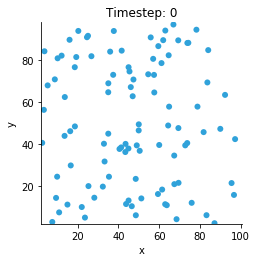
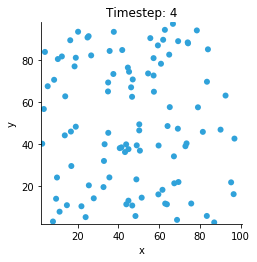
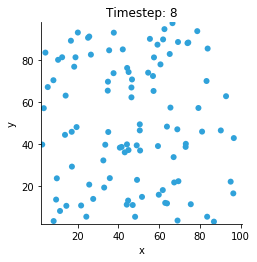
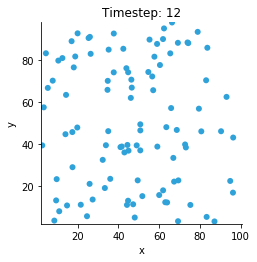
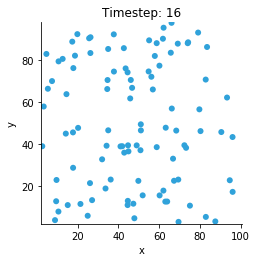
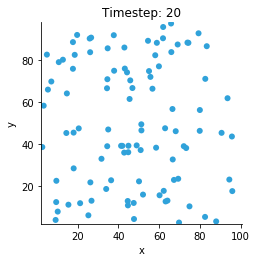
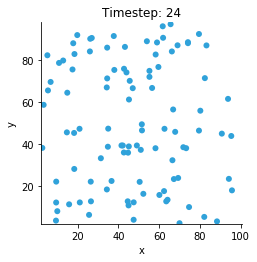
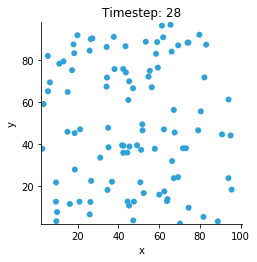
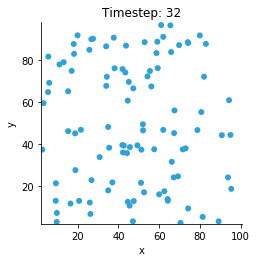
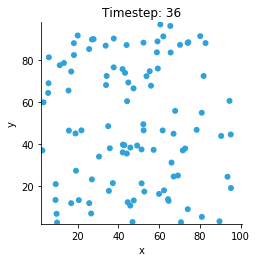
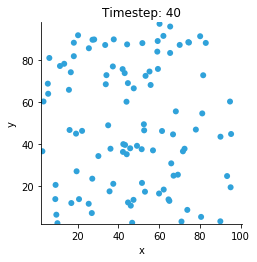
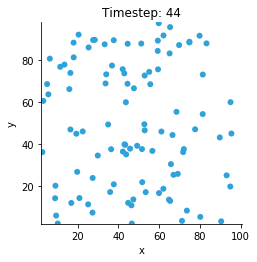
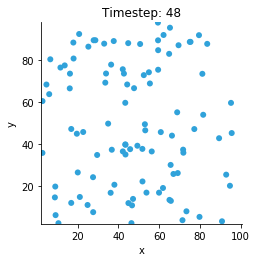
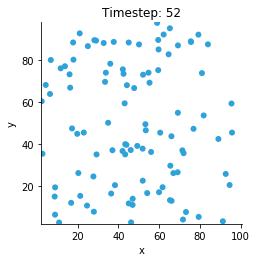
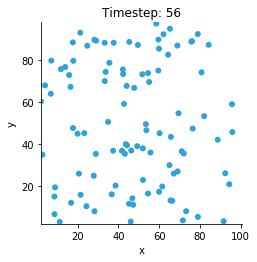
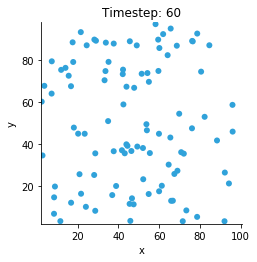
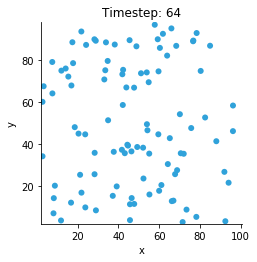
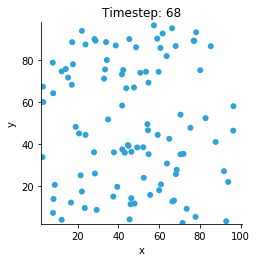
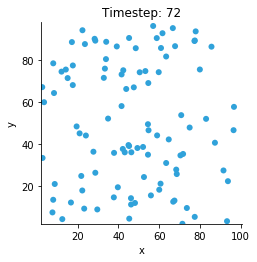
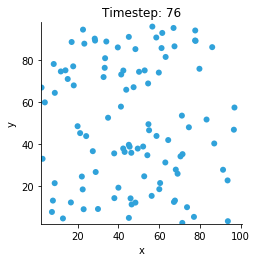
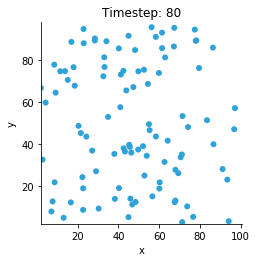
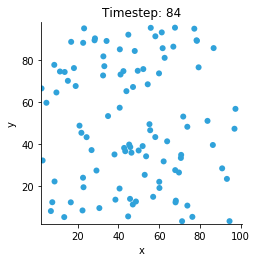
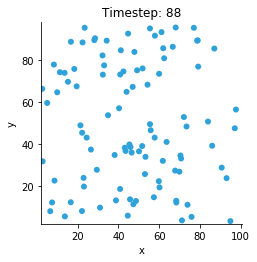
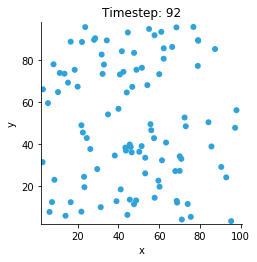
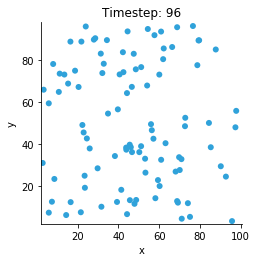
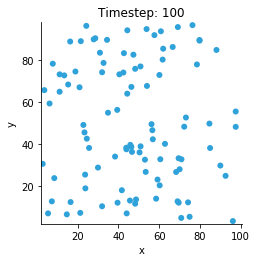
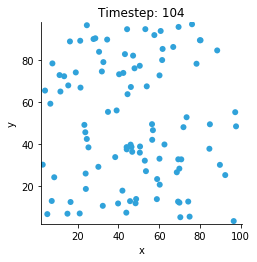
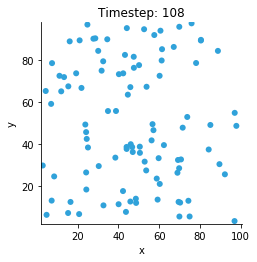
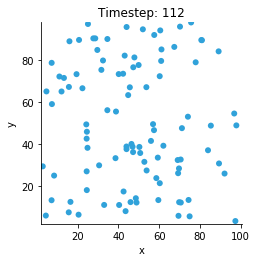
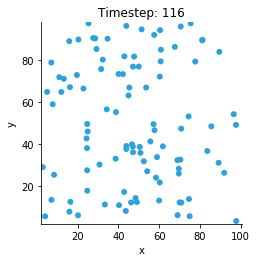
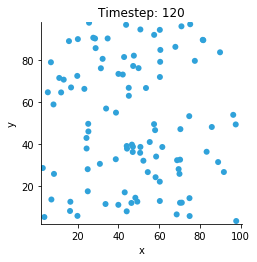
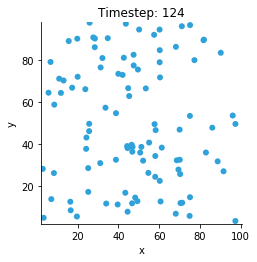
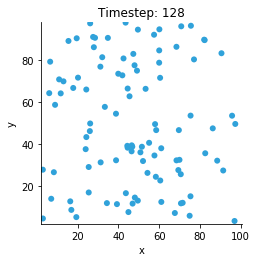
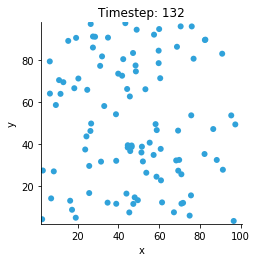
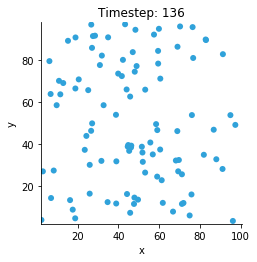
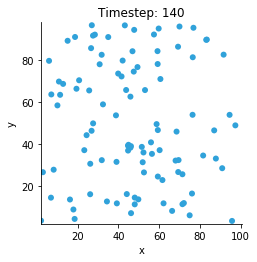
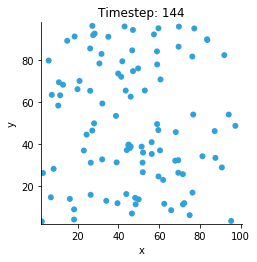
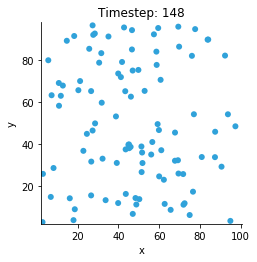
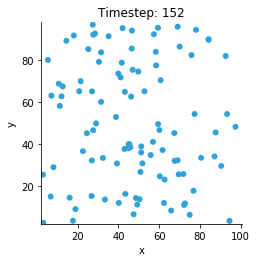
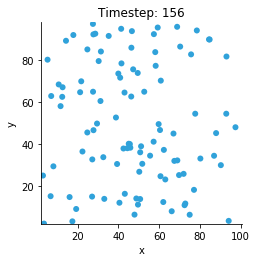
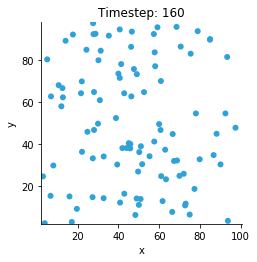
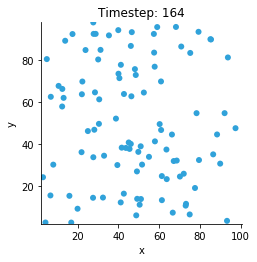
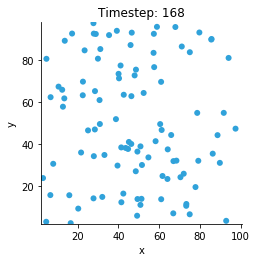
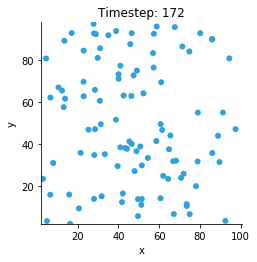
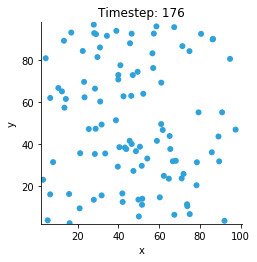
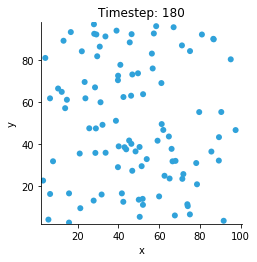
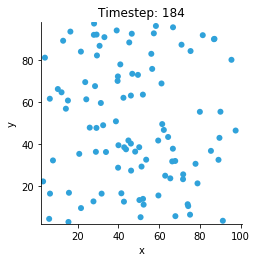
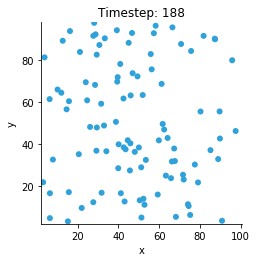
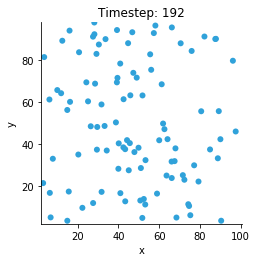
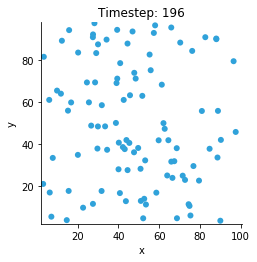
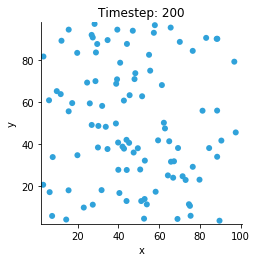
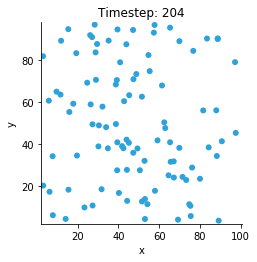
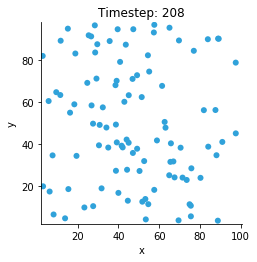
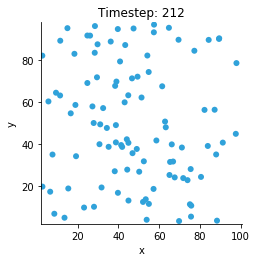
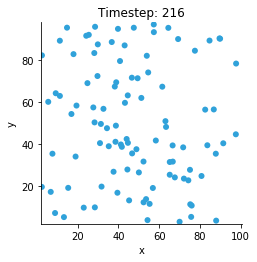
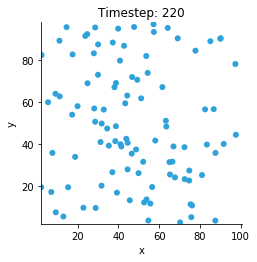
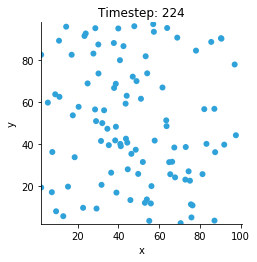
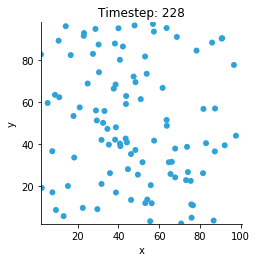
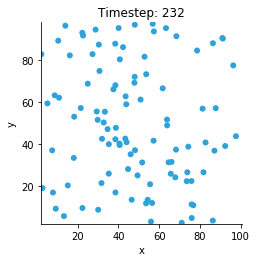
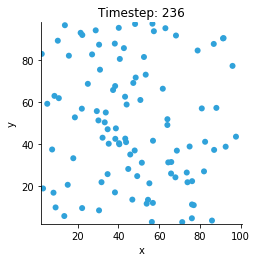
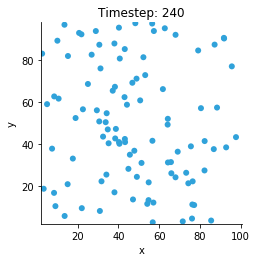
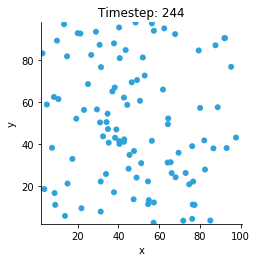
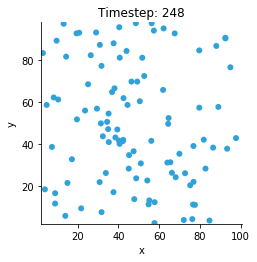
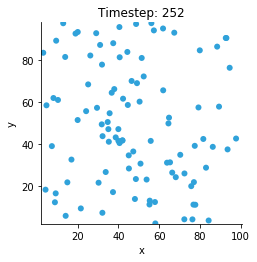
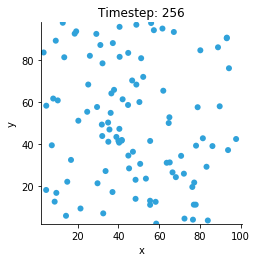
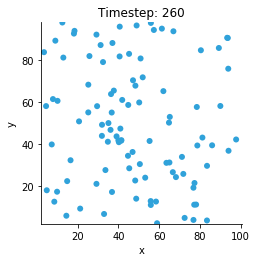
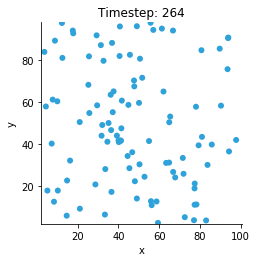
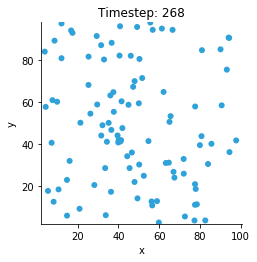
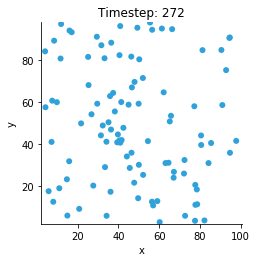
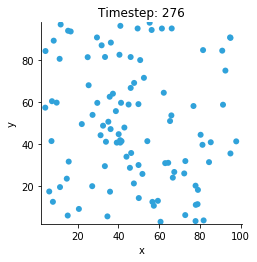
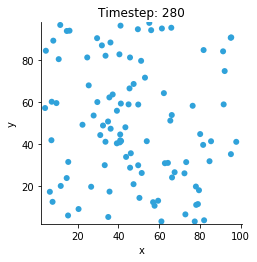
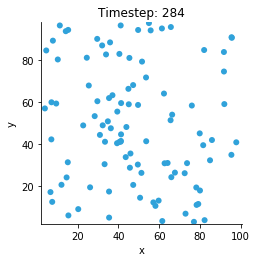
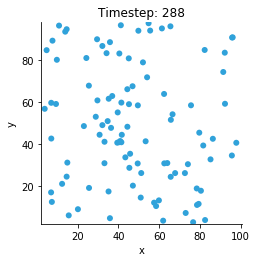
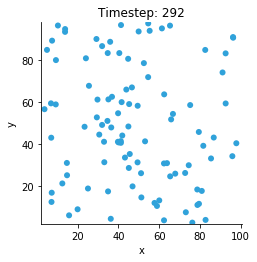
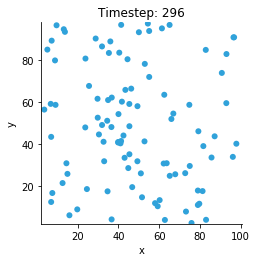
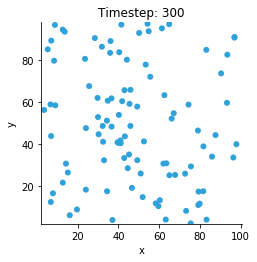
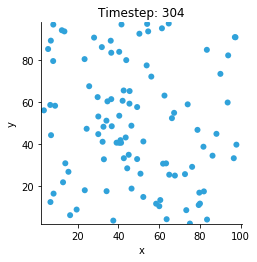
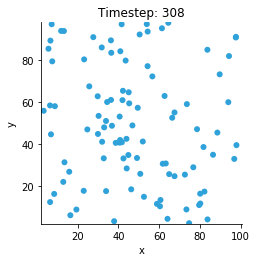
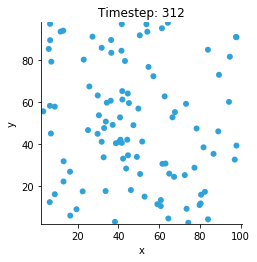
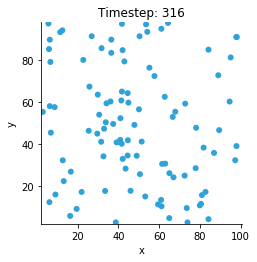
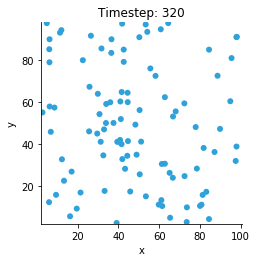
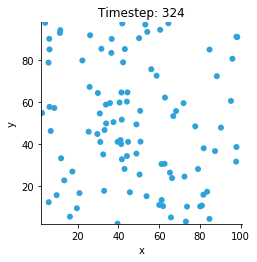
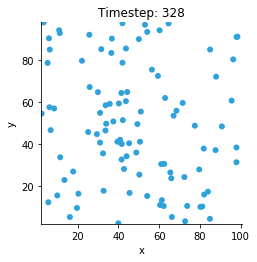
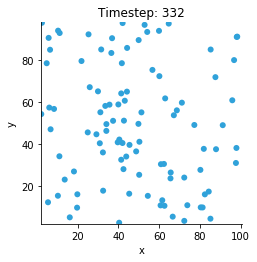
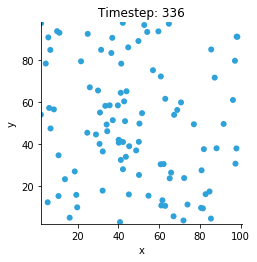
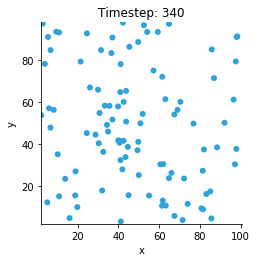
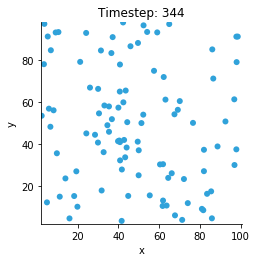
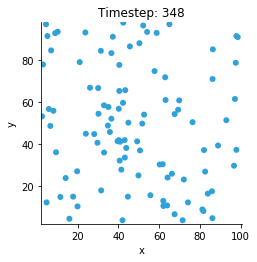
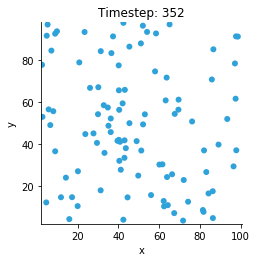
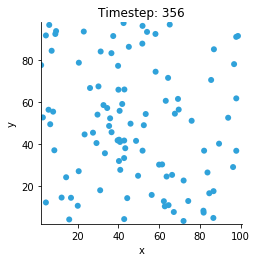
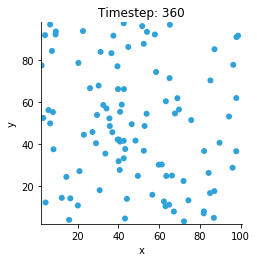
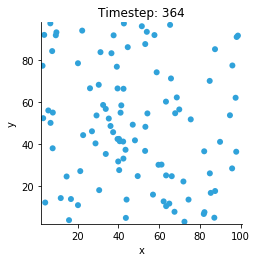
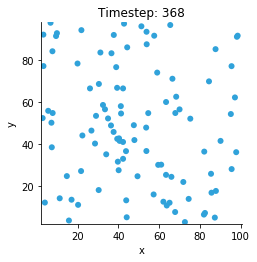
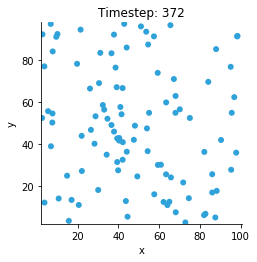
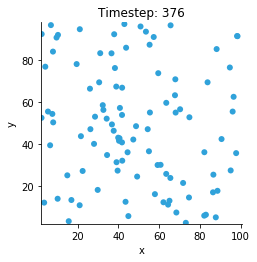
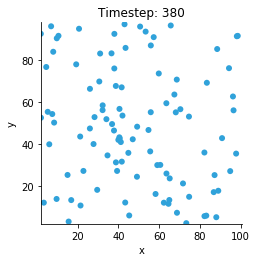
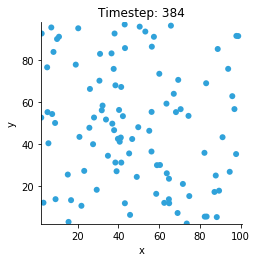
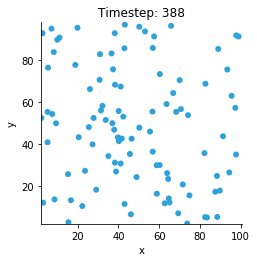
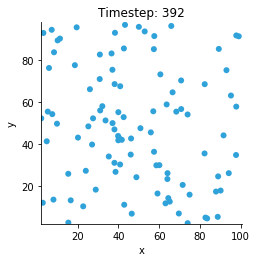
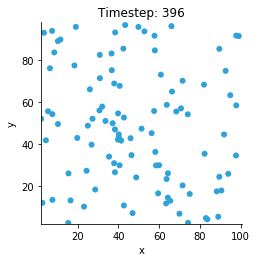
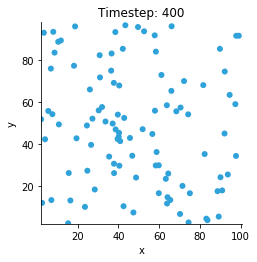
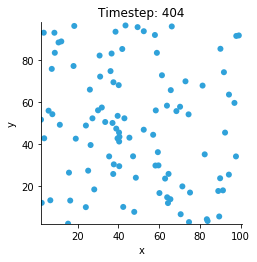
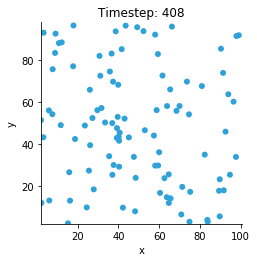
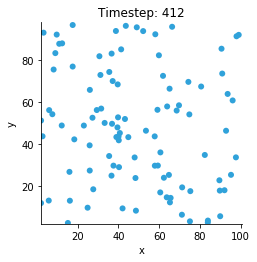
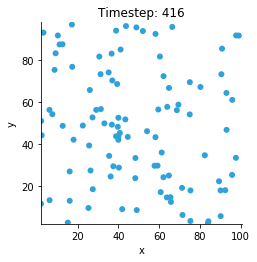
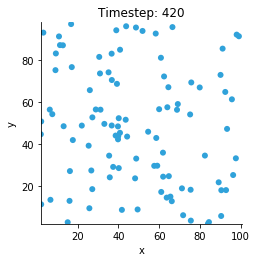
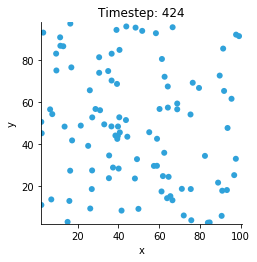
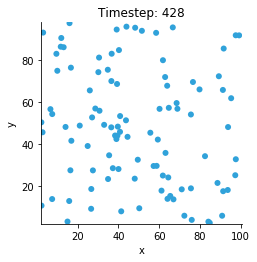
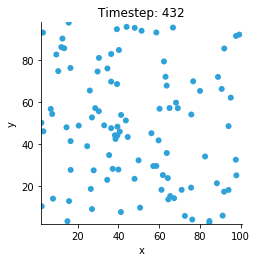
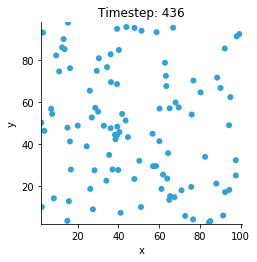
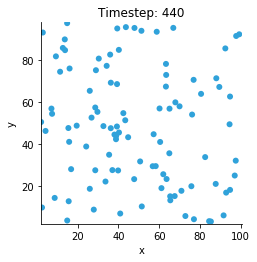
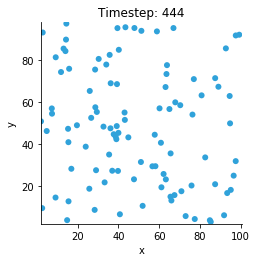
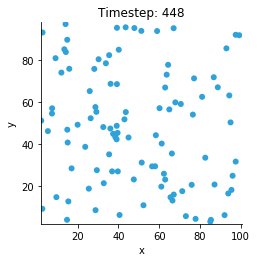
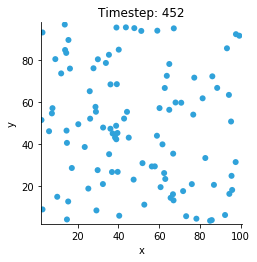
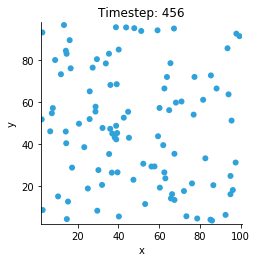
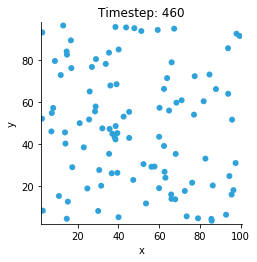
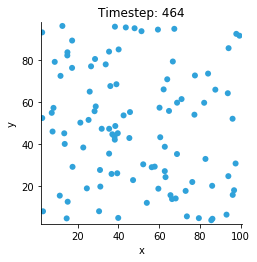
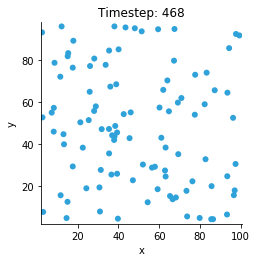
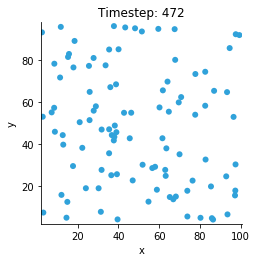
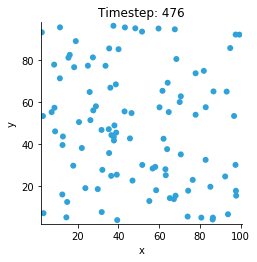
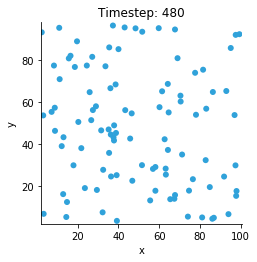
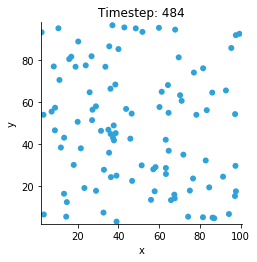
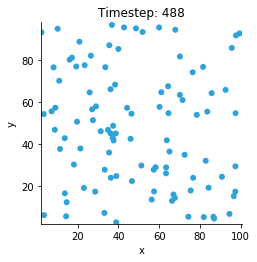
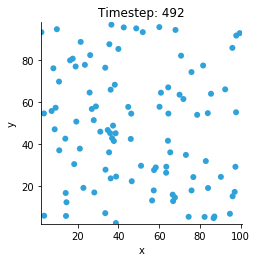
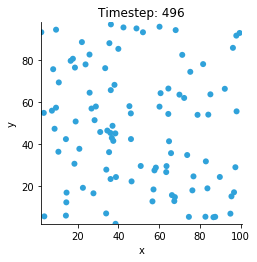
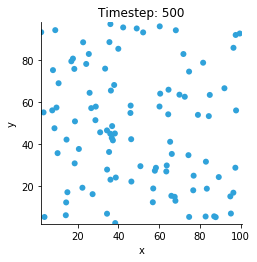
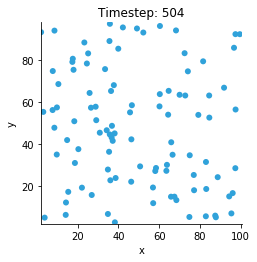
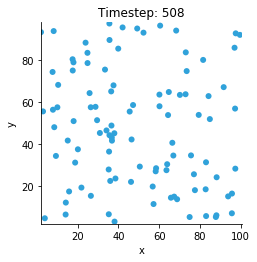
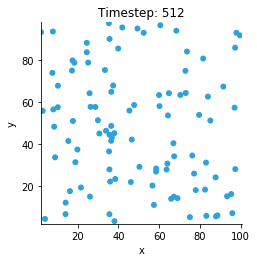
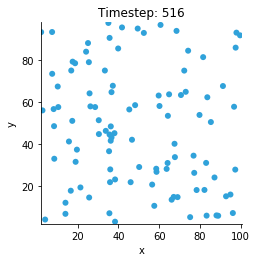
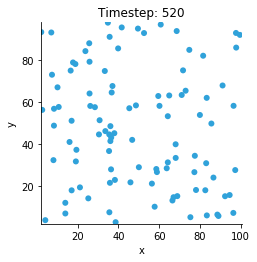
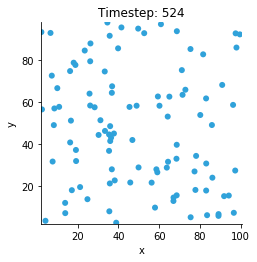
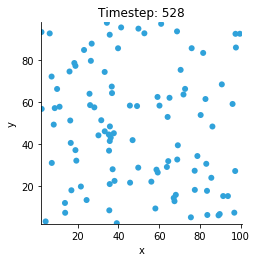
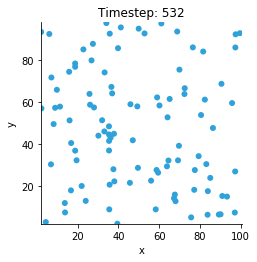
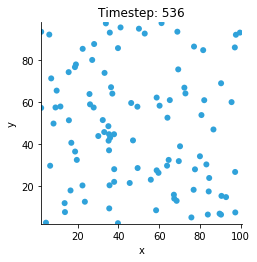
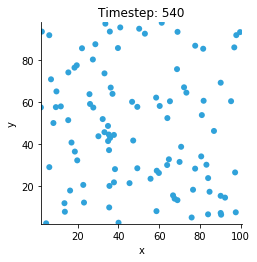
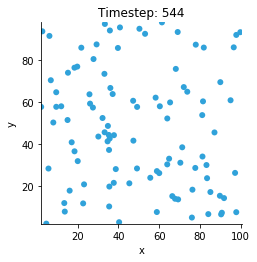
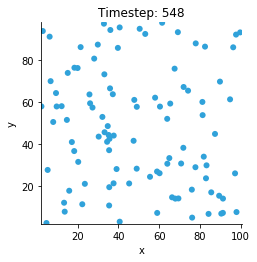
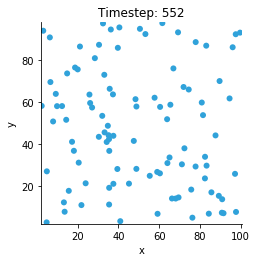
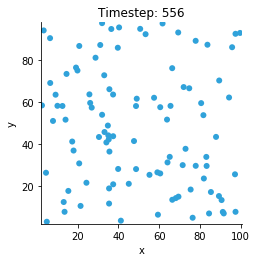
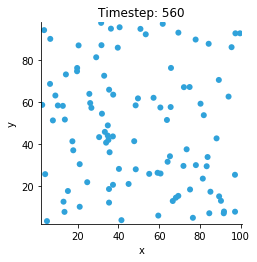
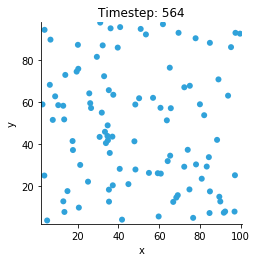
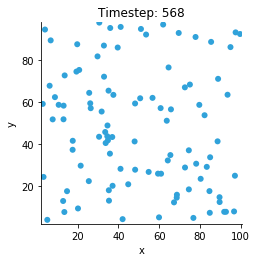
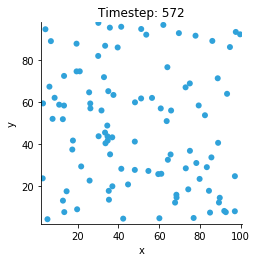
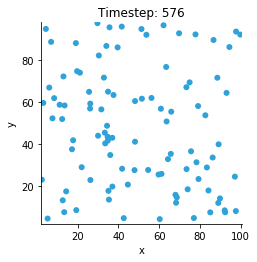
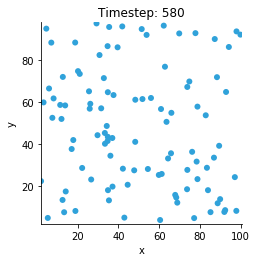
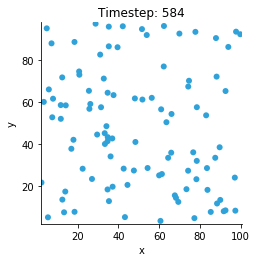
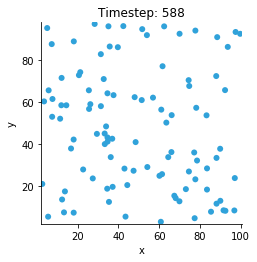
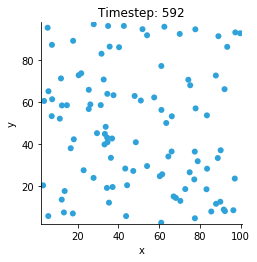
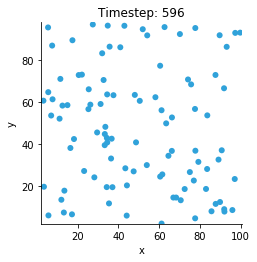
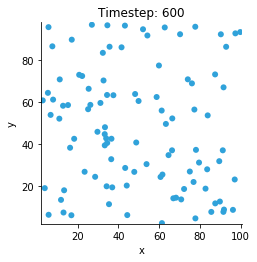
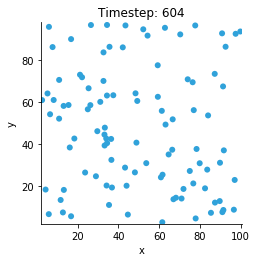
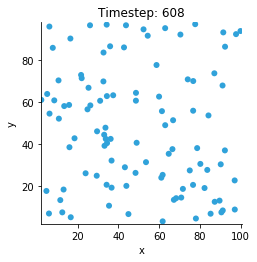
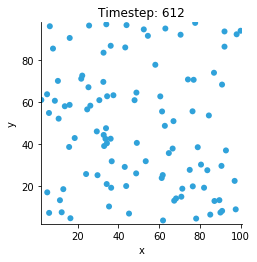
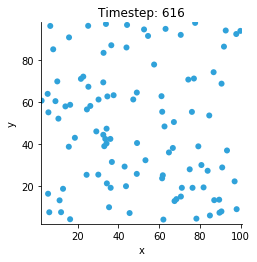
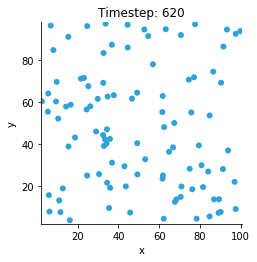
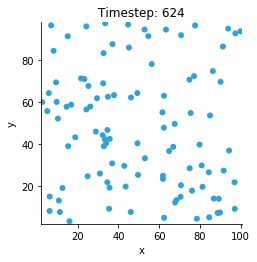
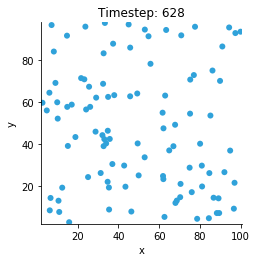
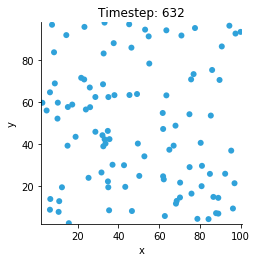
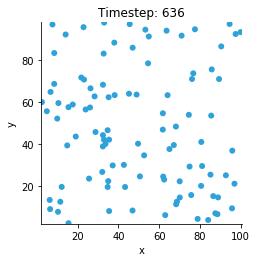
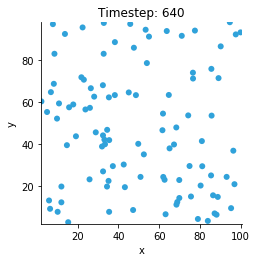
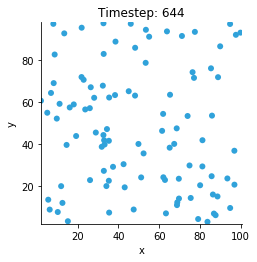
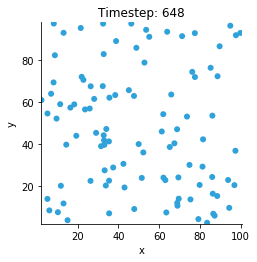
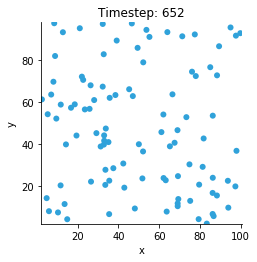
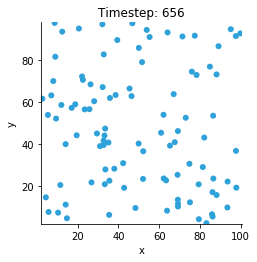
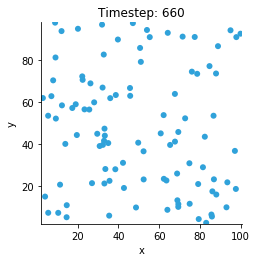
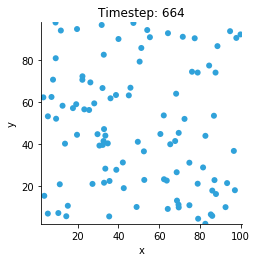
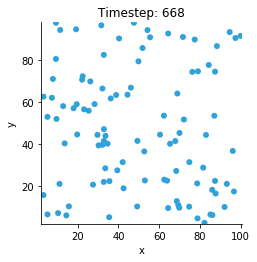
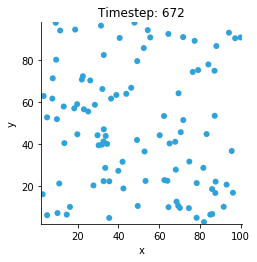
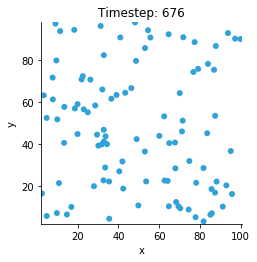
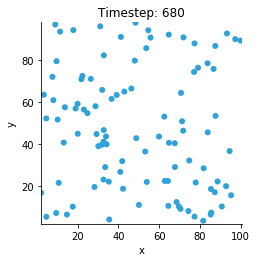
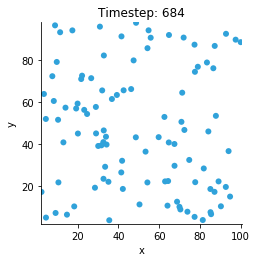
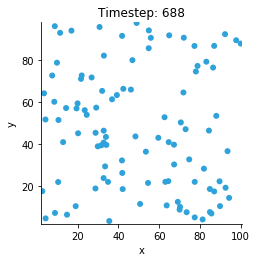
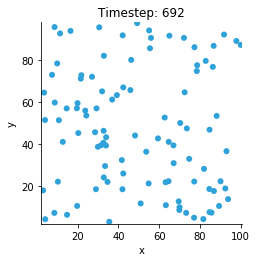
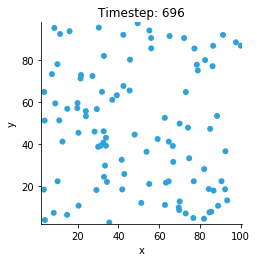
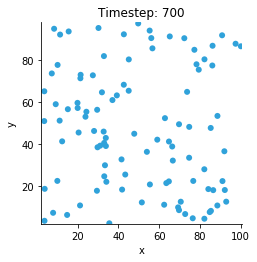
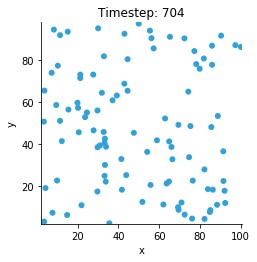
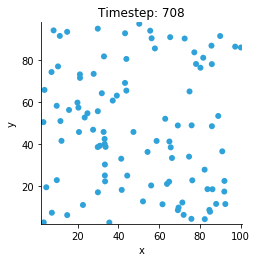
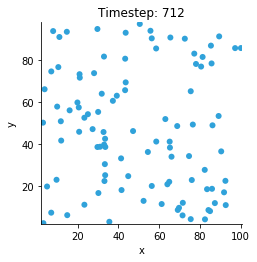
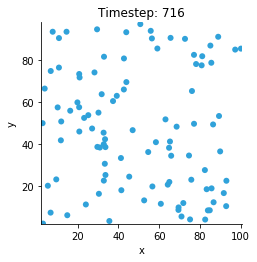
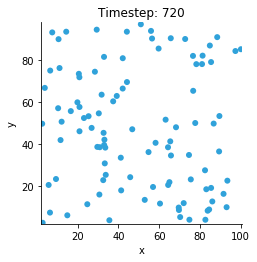
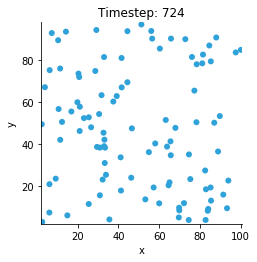
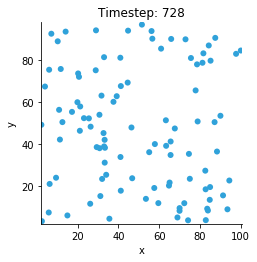
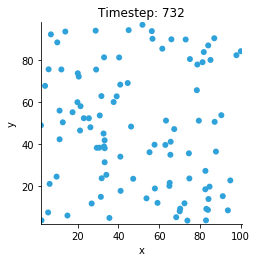
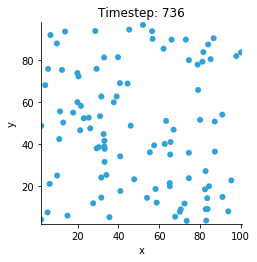
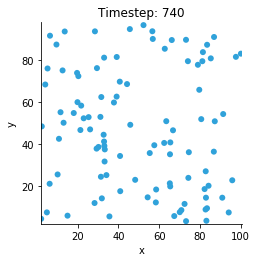
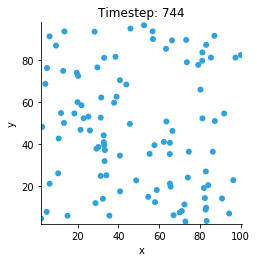
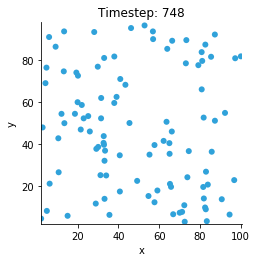
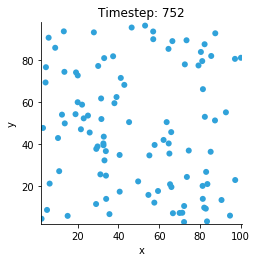
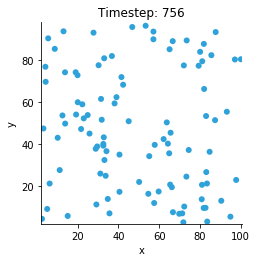
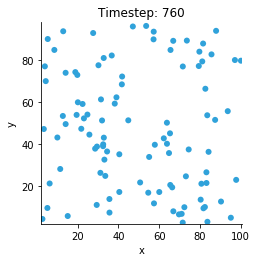
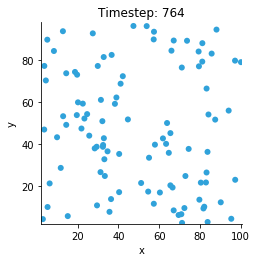
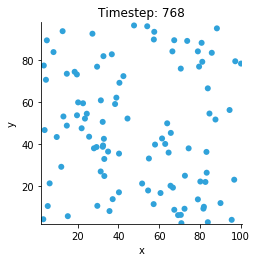
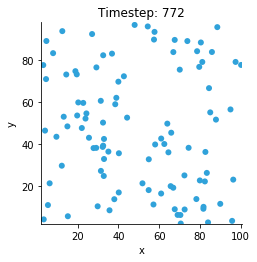
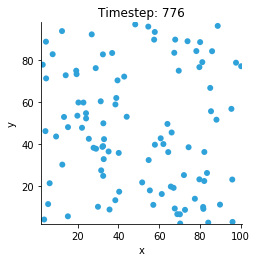
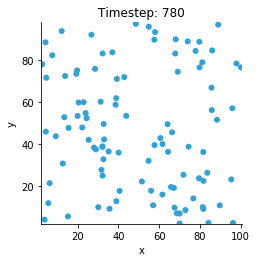
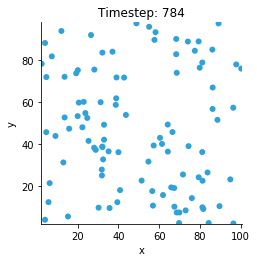
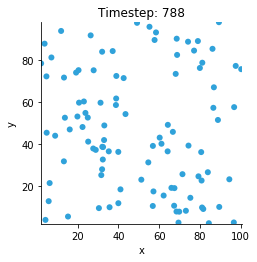
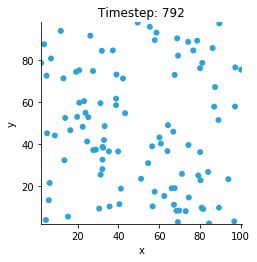
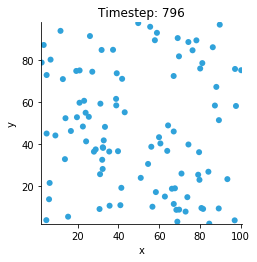
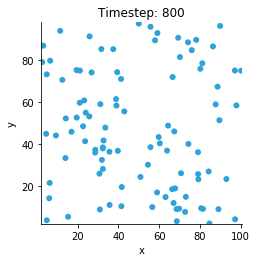
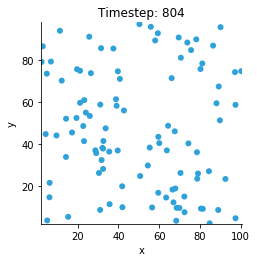
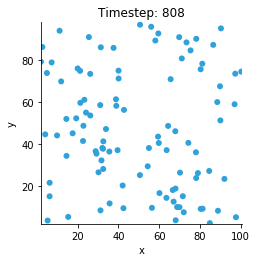
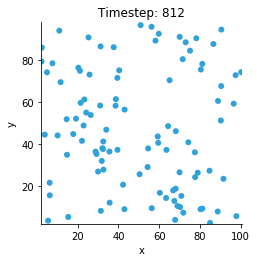
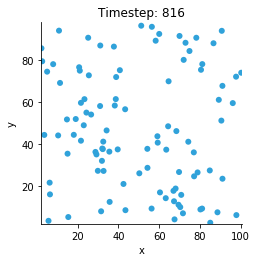
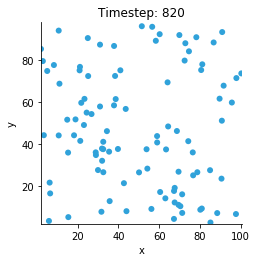
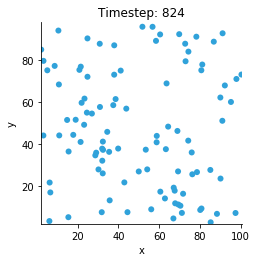
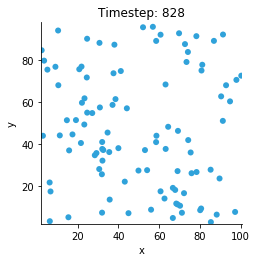
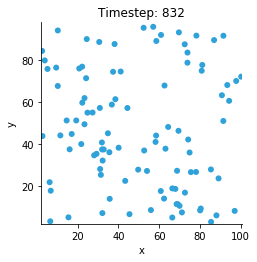
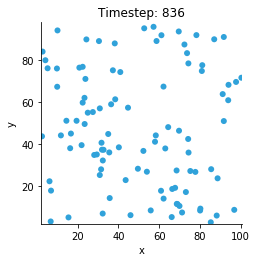
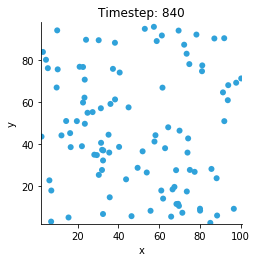
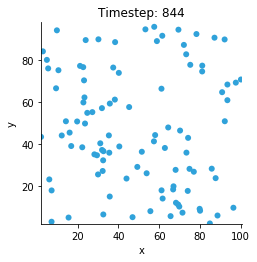
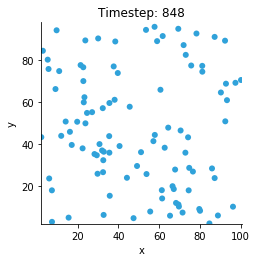
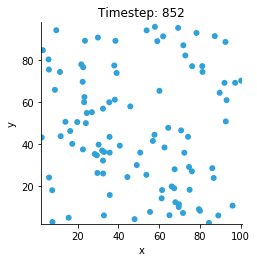
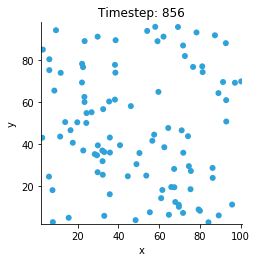
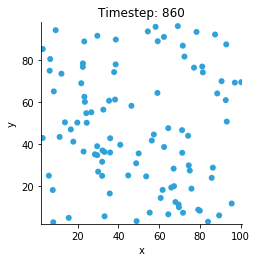
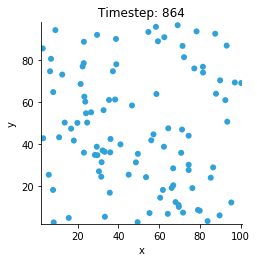
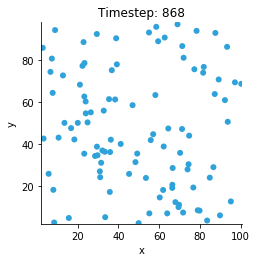
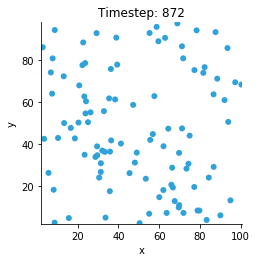
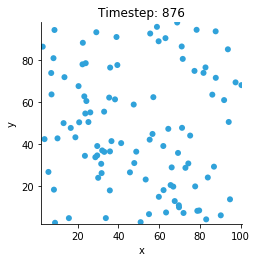
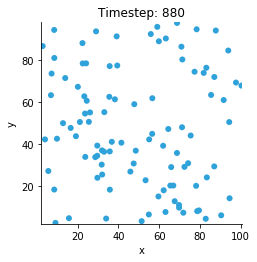
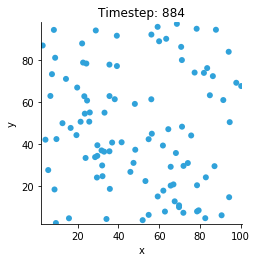
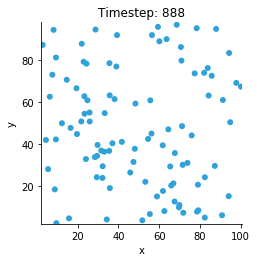
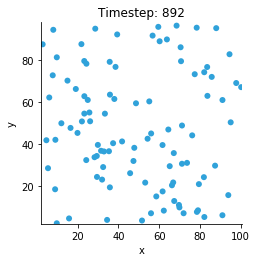
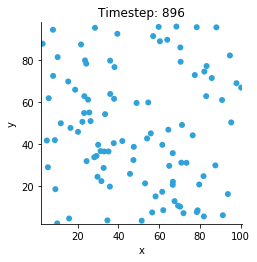
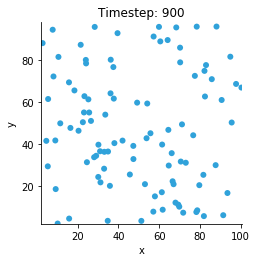
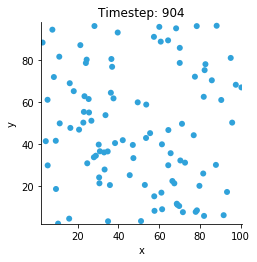
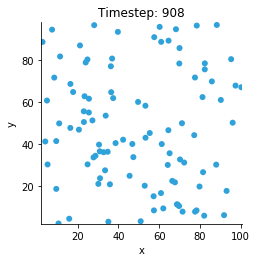
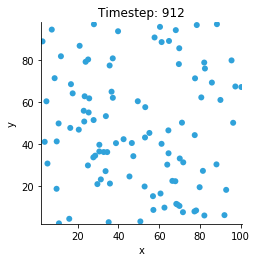
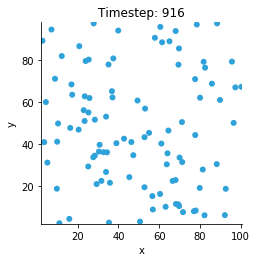
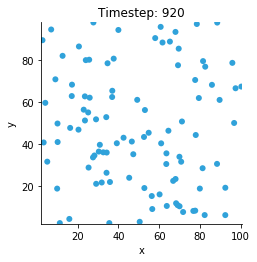
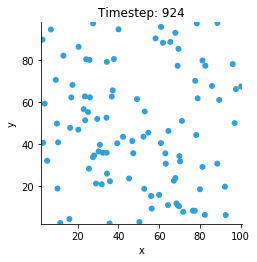
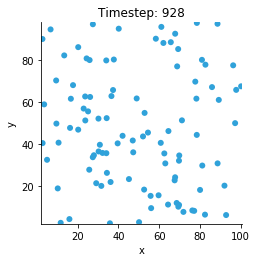
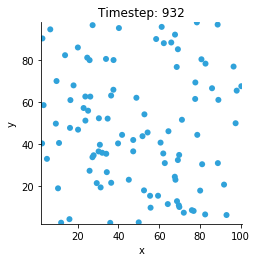
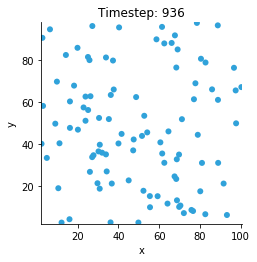
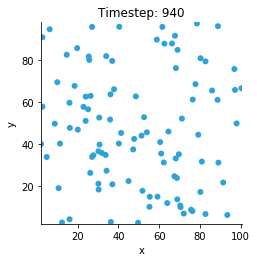
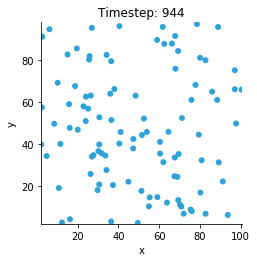
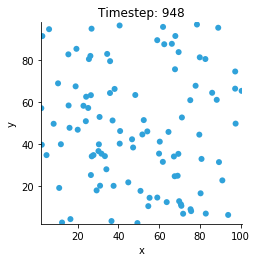
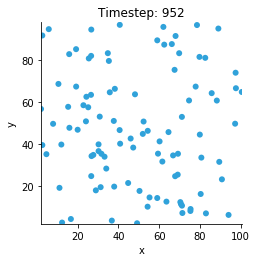
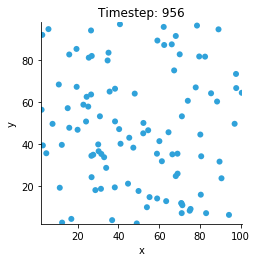
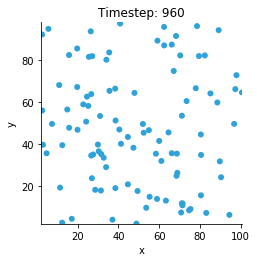
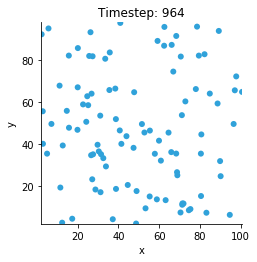
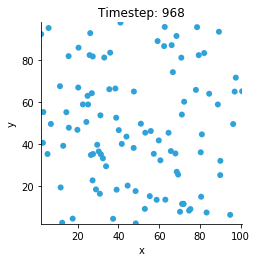
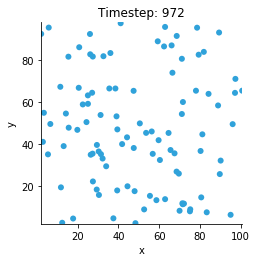
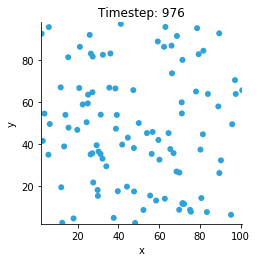
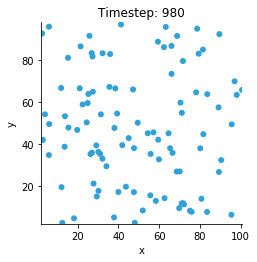
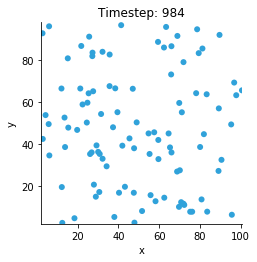
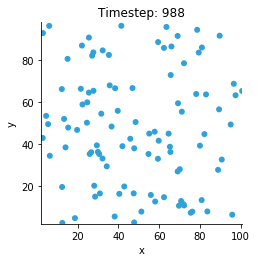
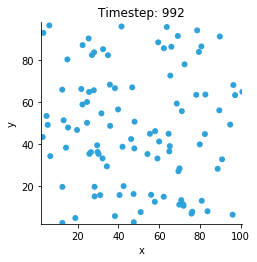
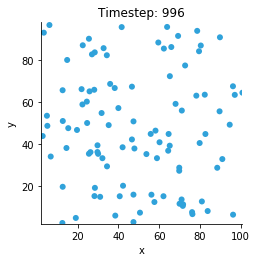
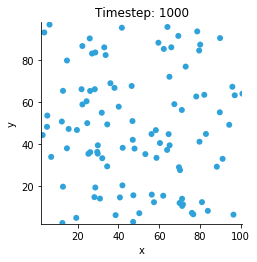

In [4]:
# position slider plot
pos_hmap = hv.HoloMap(pos_dict_hv, kdims='Timestep')
pos_hmap

:HoloMap   [Timestep]
   :Histogram   [x]   (Frequency)
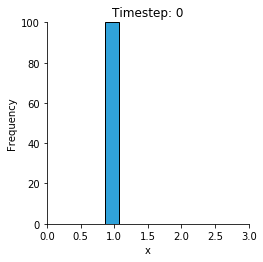
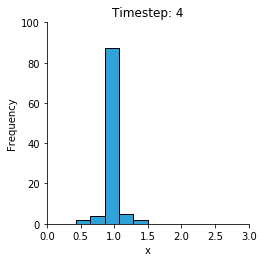
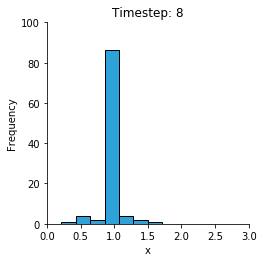
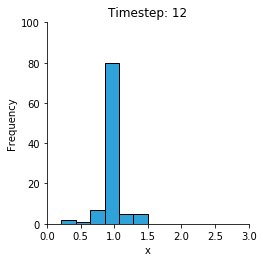
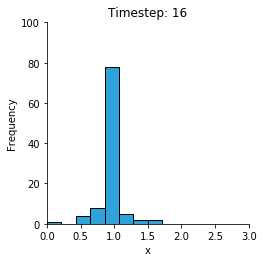
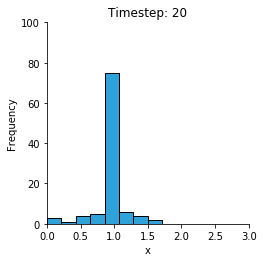
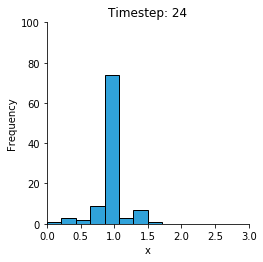
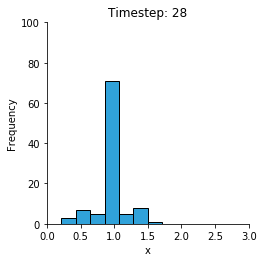
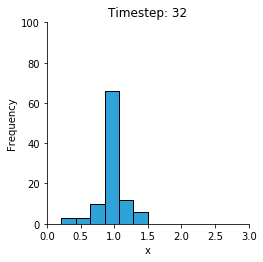
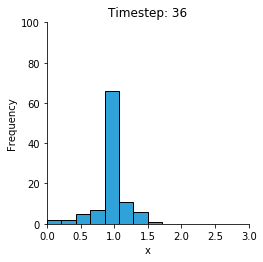
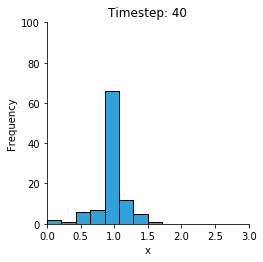
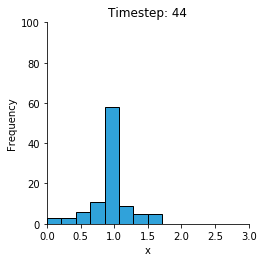
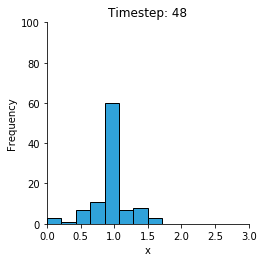
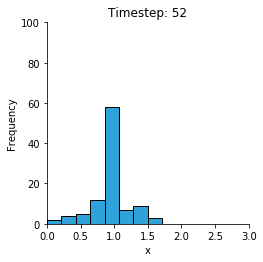
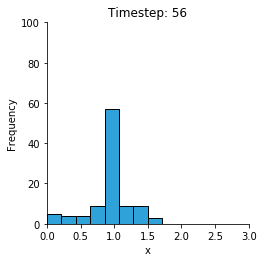
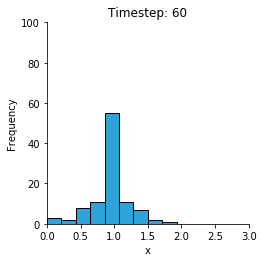
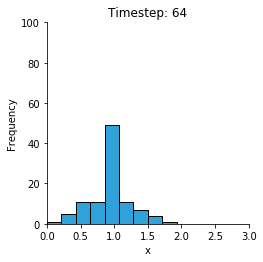
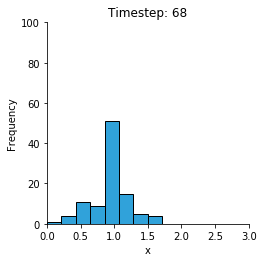
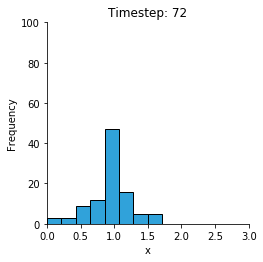
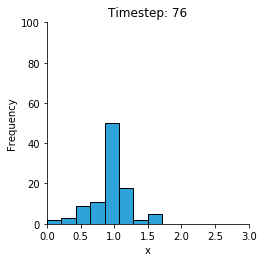
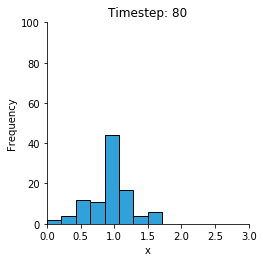
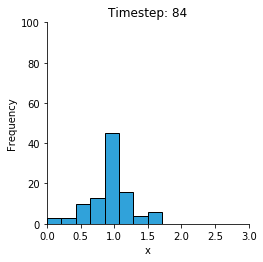
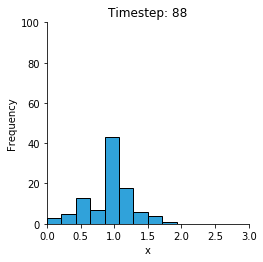
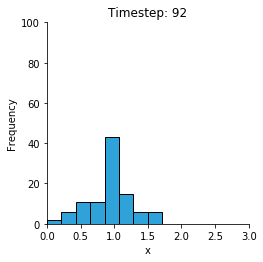
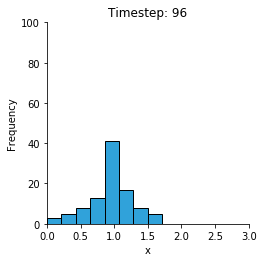
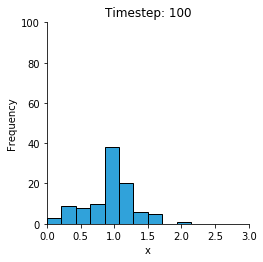
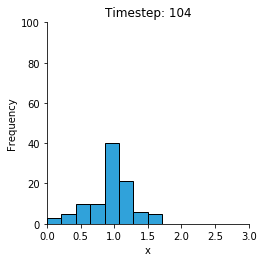
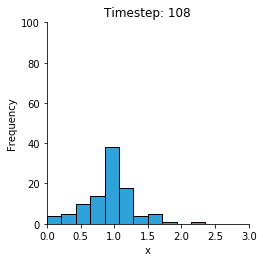
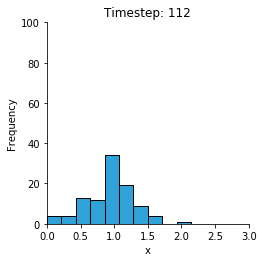
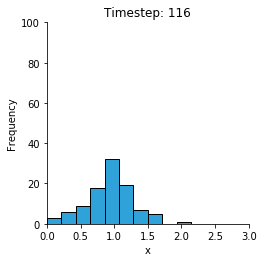
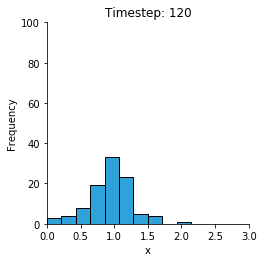
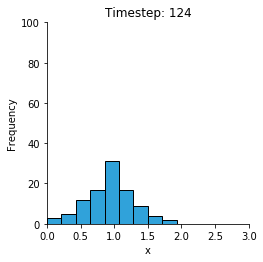
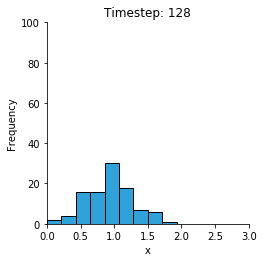
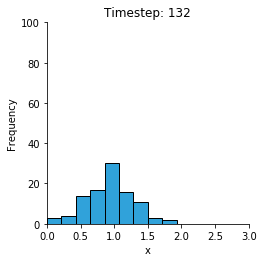
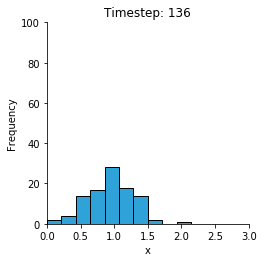
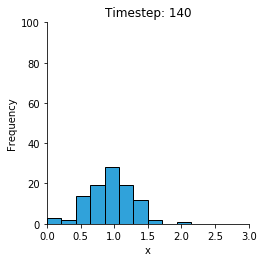
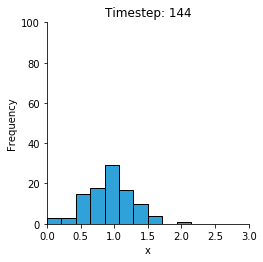
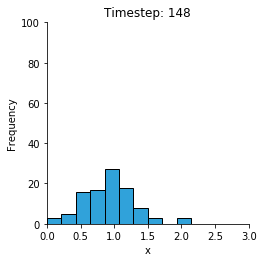
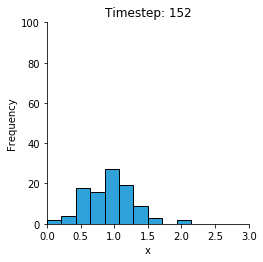
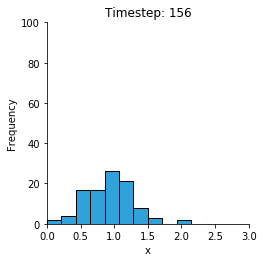
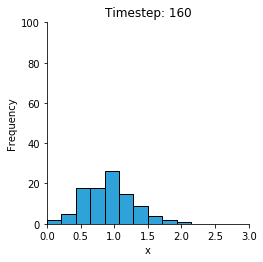
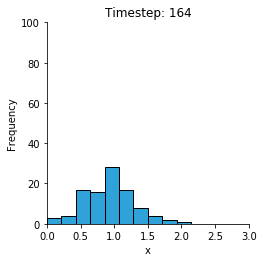
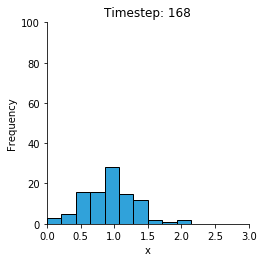
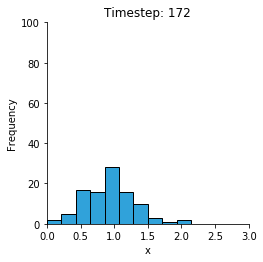
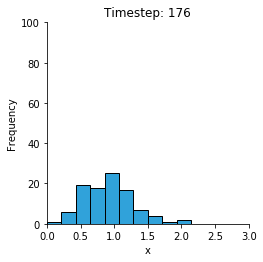
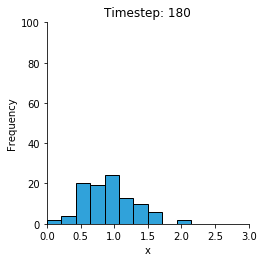
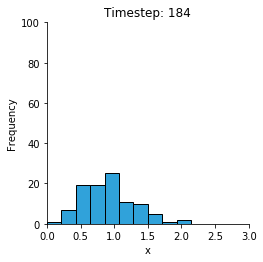
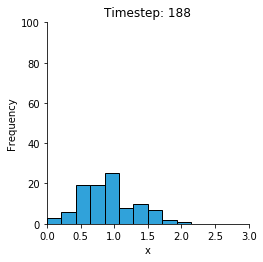
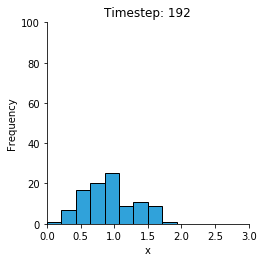
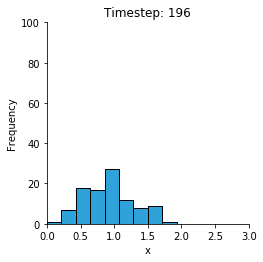
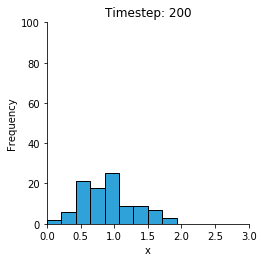
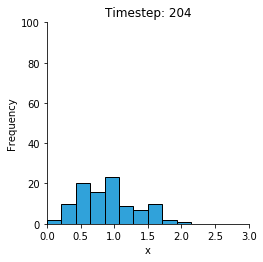
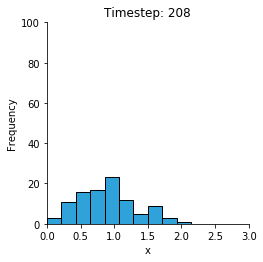
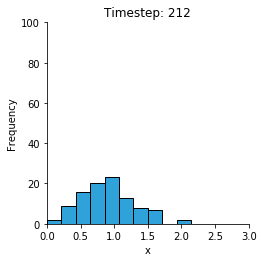
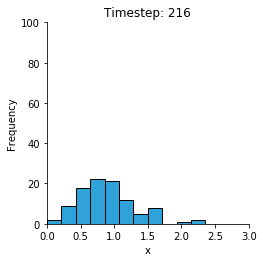
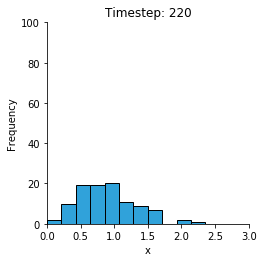
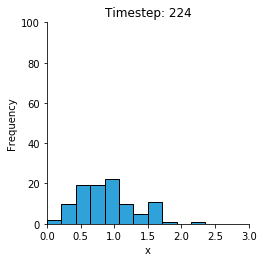
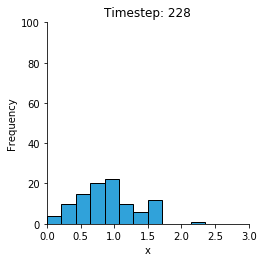
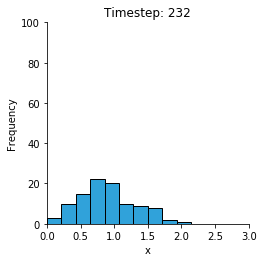
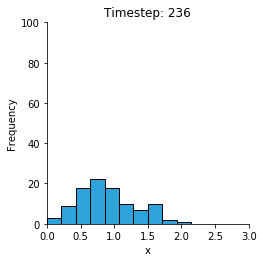
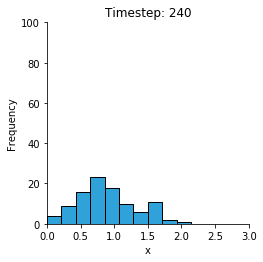
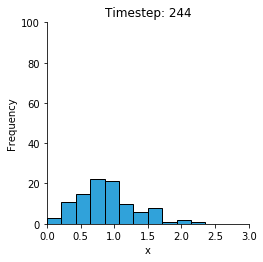
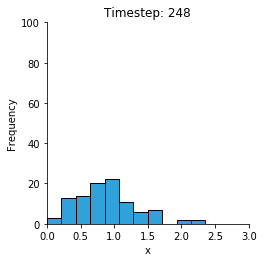
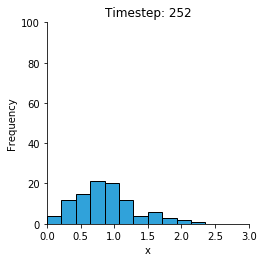
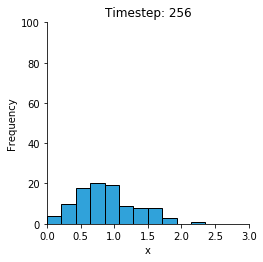
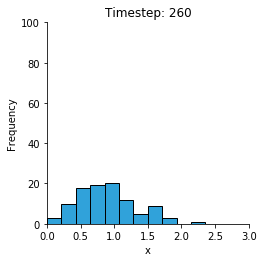
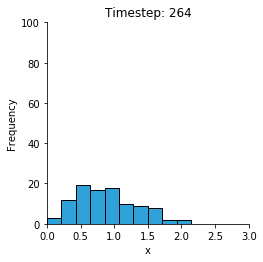
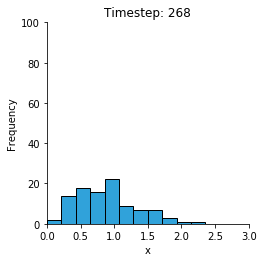
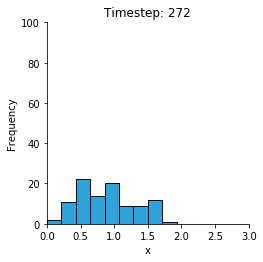
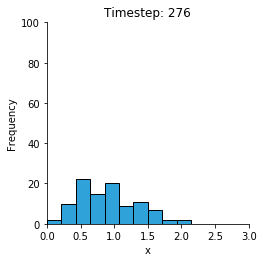
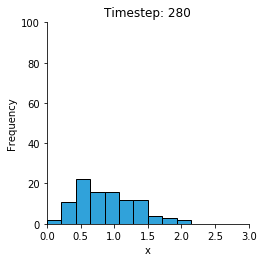
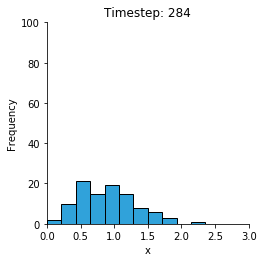
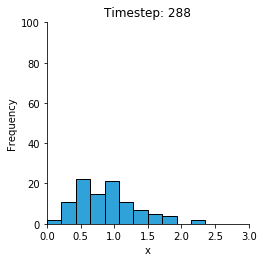
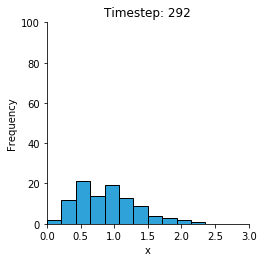
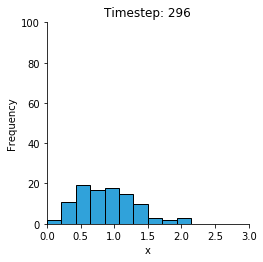
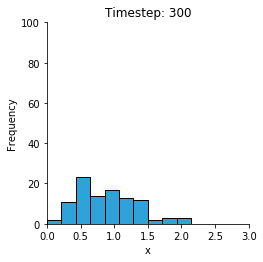
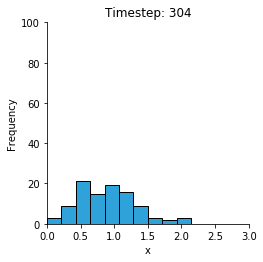
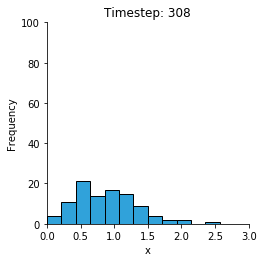
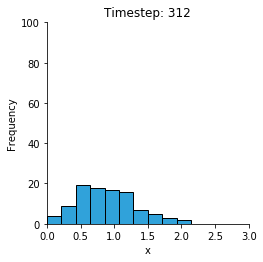
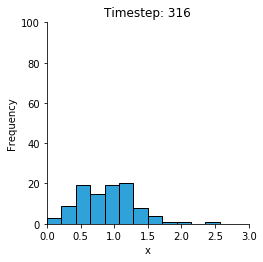
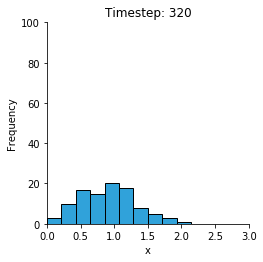
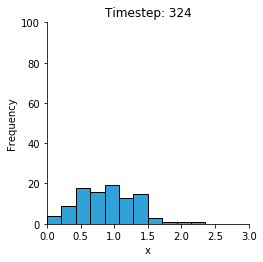
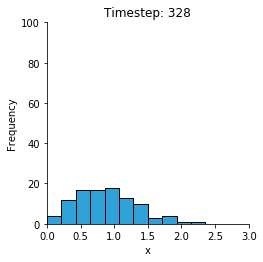
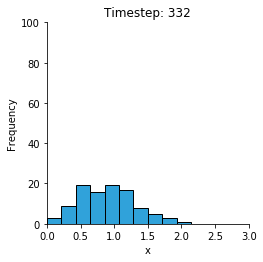
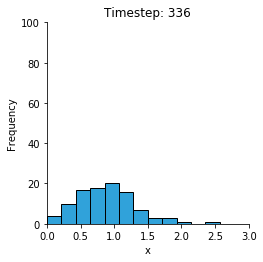
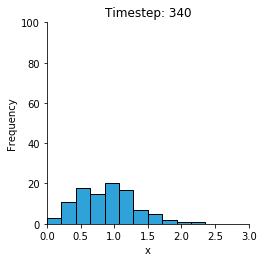
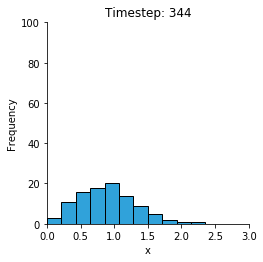
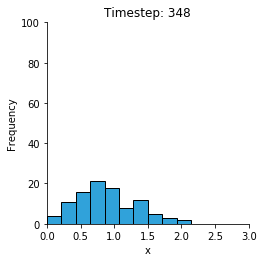
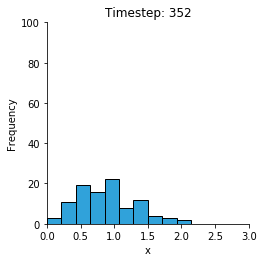
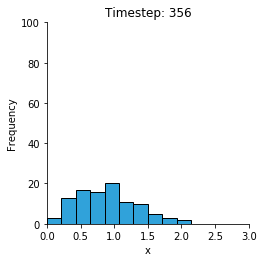
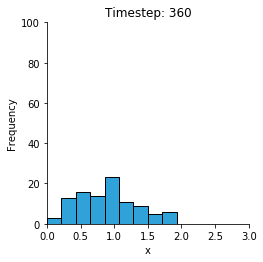
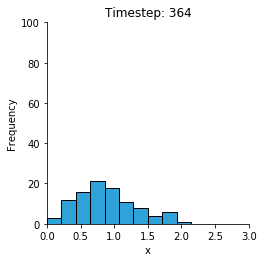
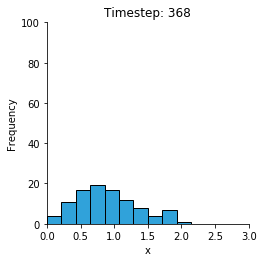
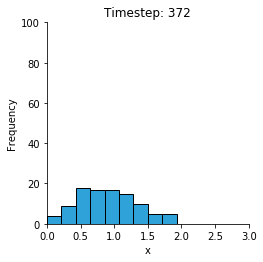
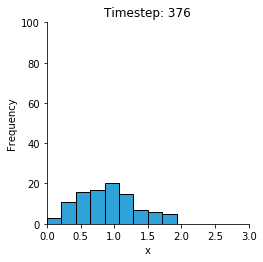
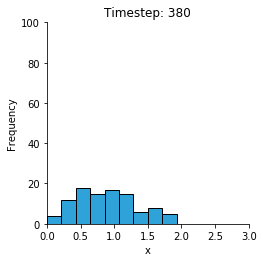
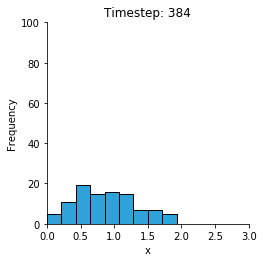
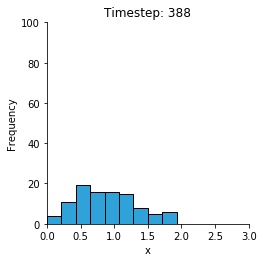
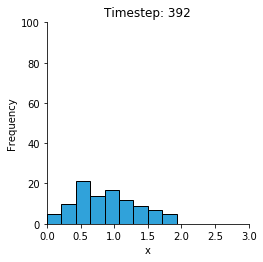
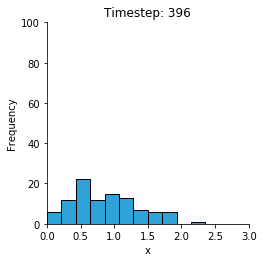
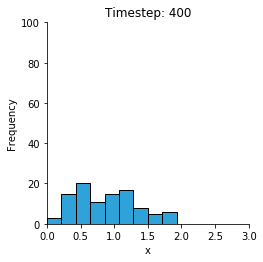
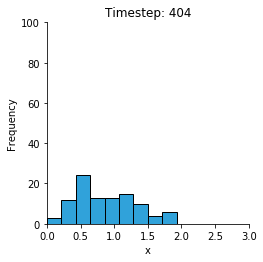
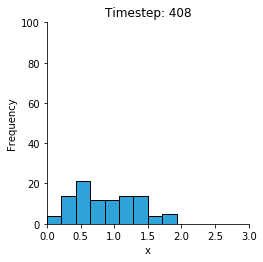
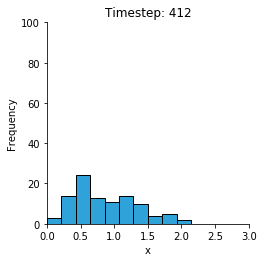
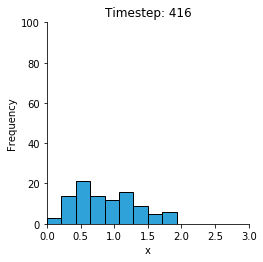
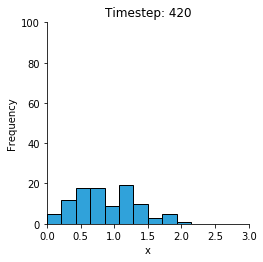
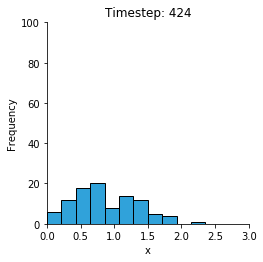
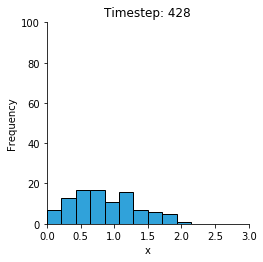
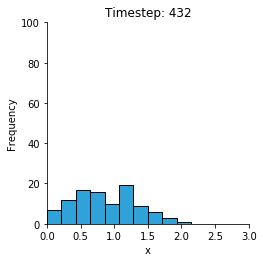
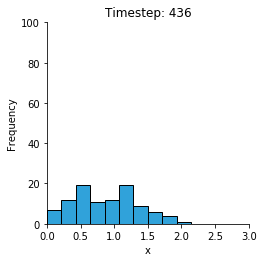
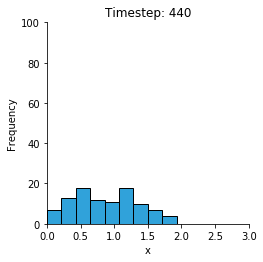
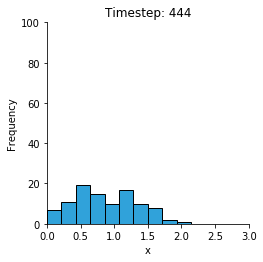
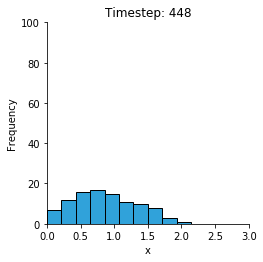
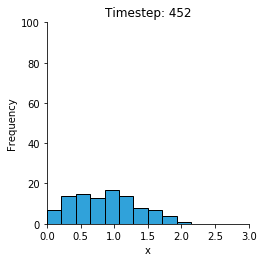
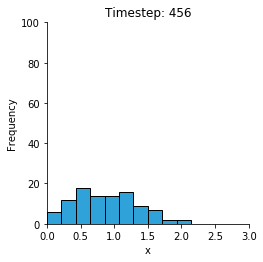
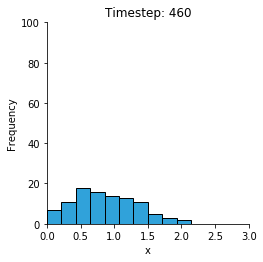
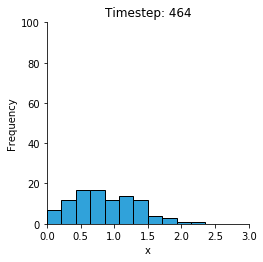
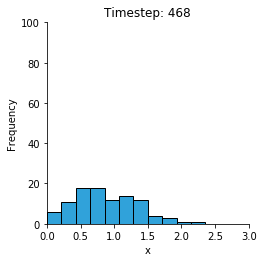
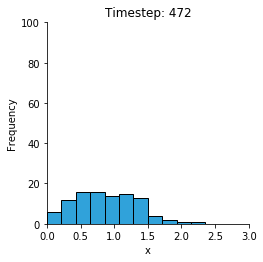
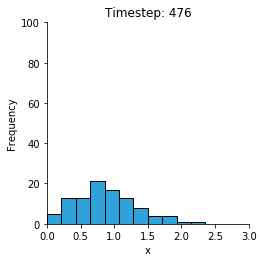
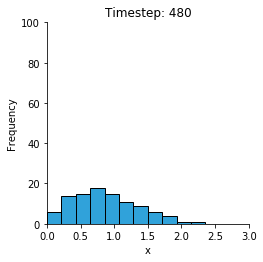
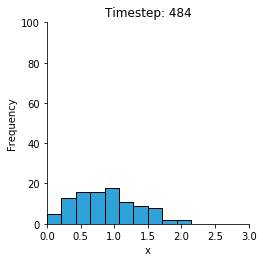
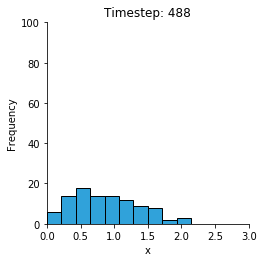
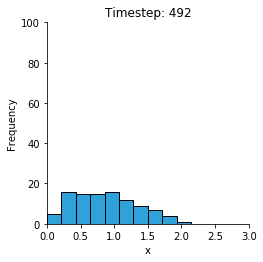
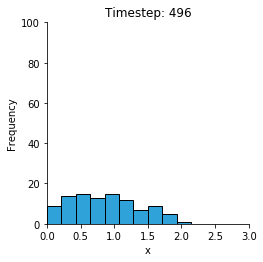
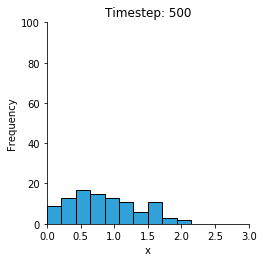
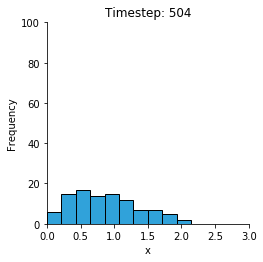
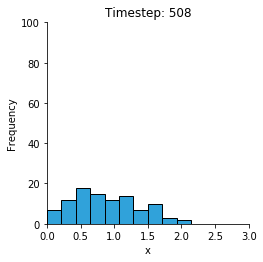
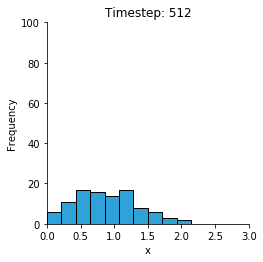
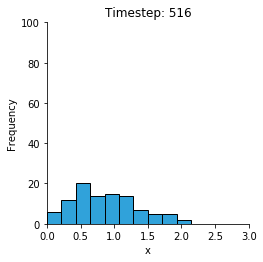
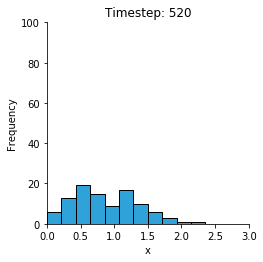
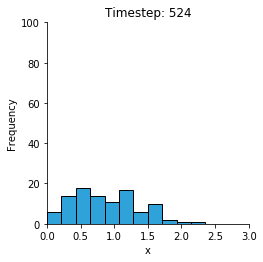
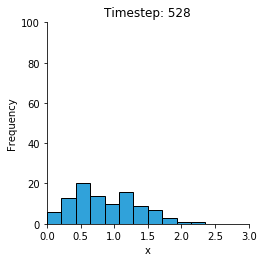
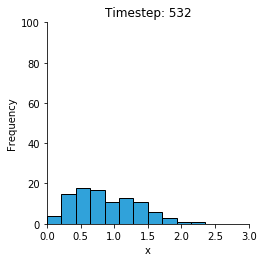
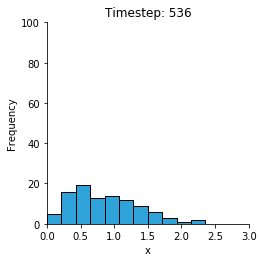
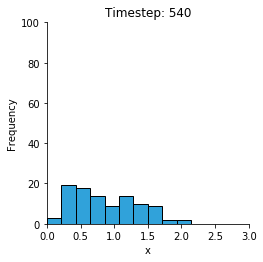
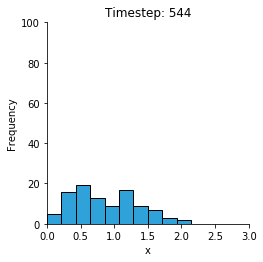
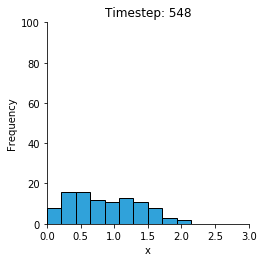
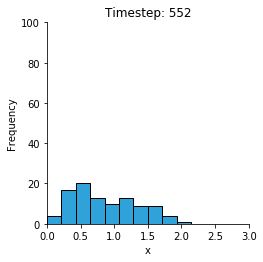
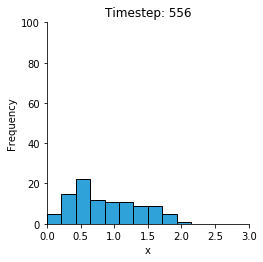
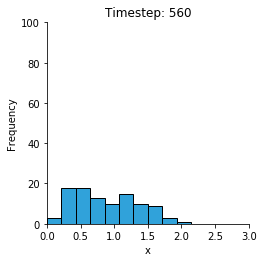
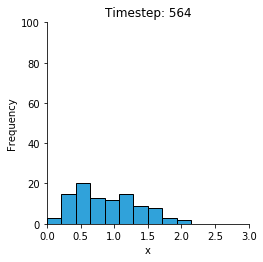
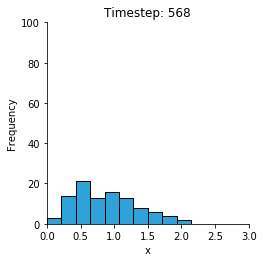
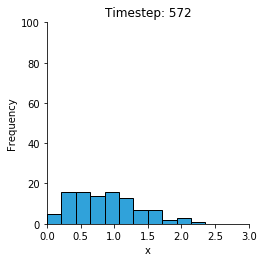
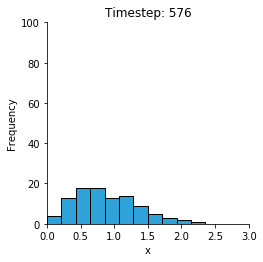
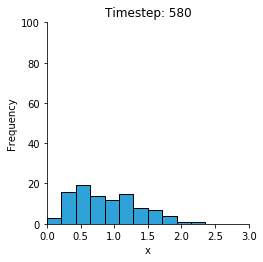
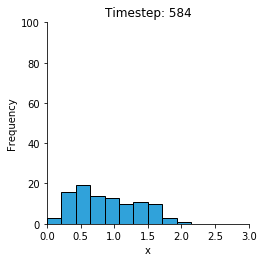
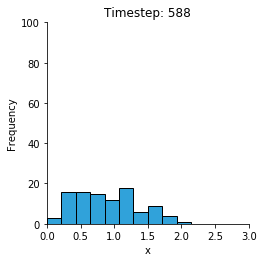
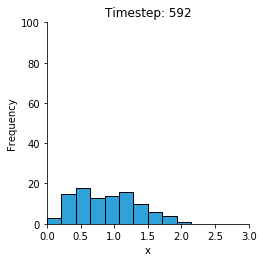
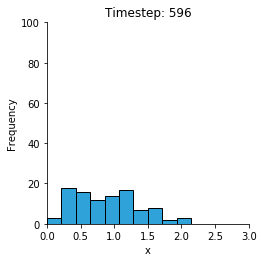
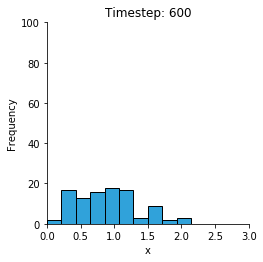
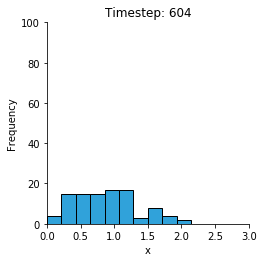
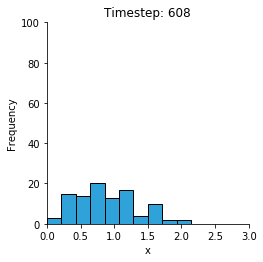
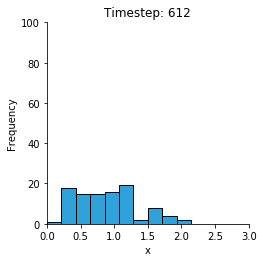
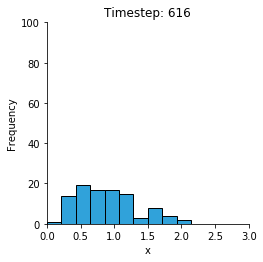
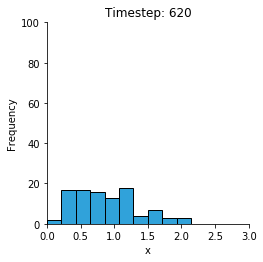
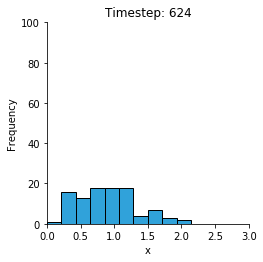
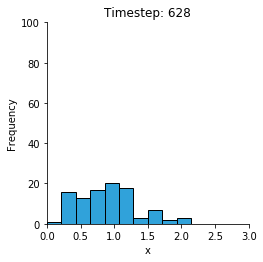
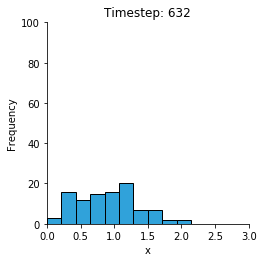
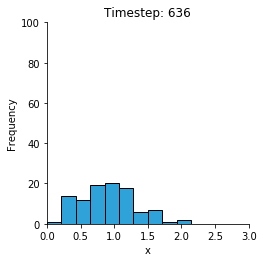
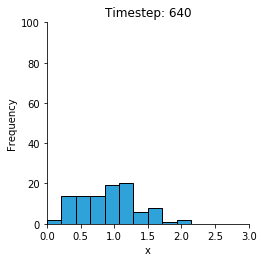
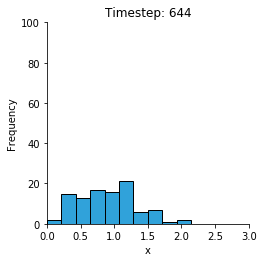
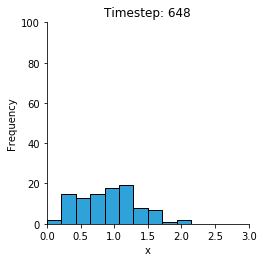
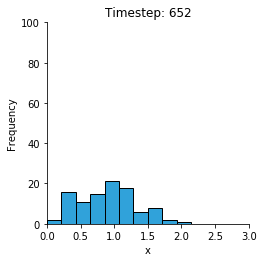
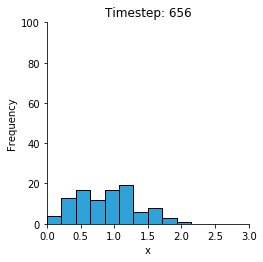
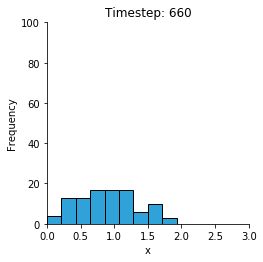
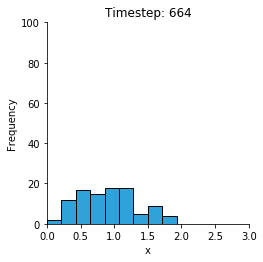
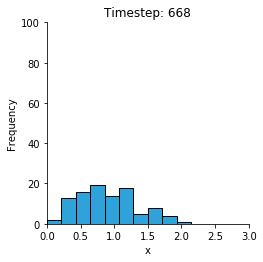
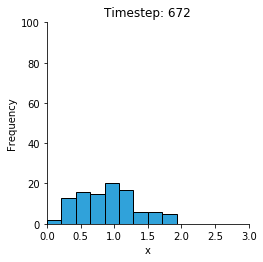
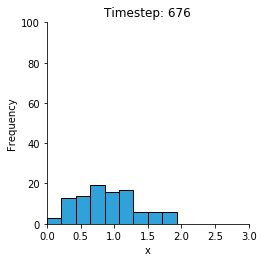
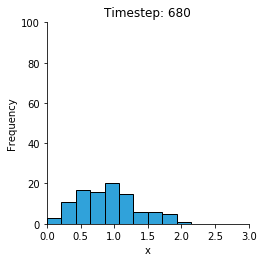
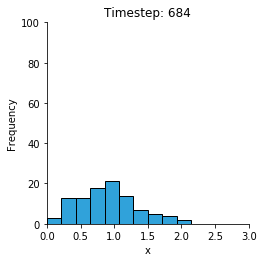
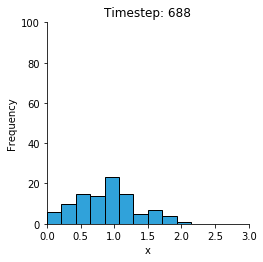
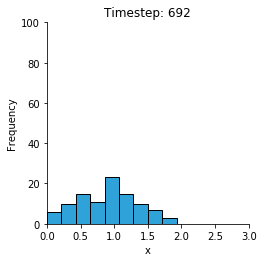
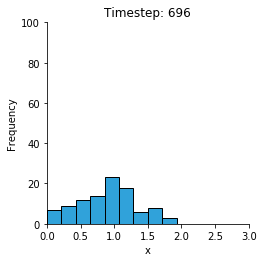
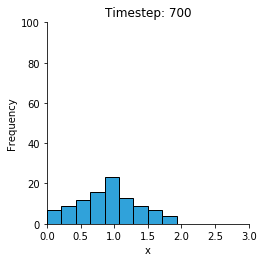
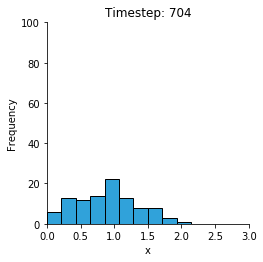
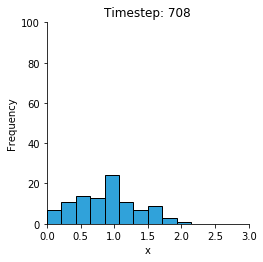
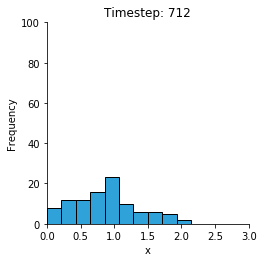
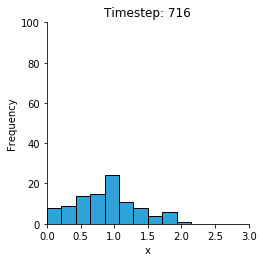
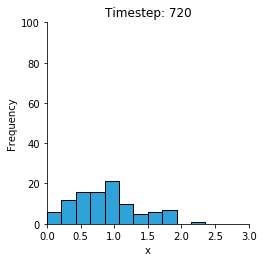
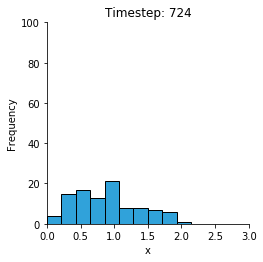
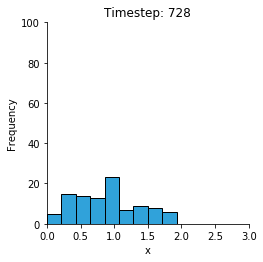
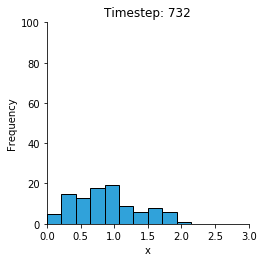
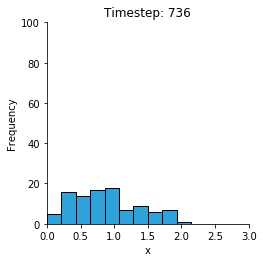
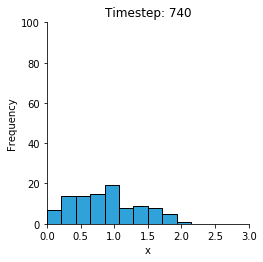
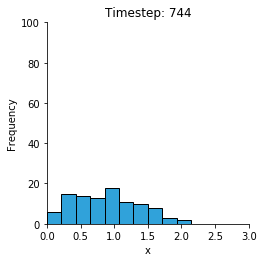
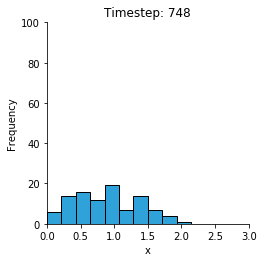
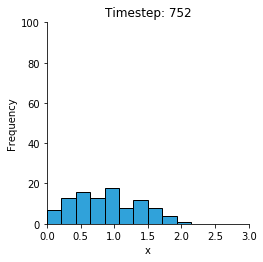
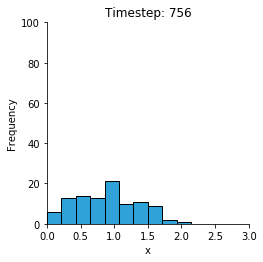
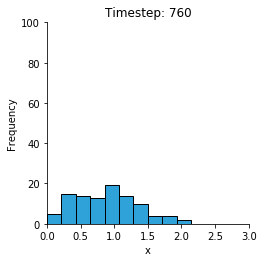
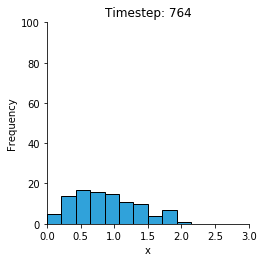
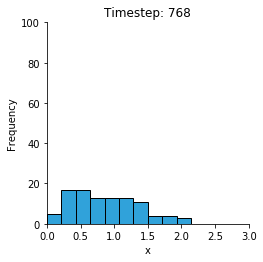
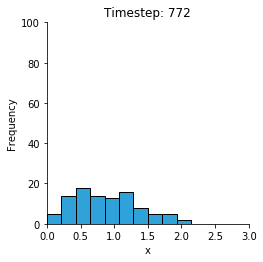
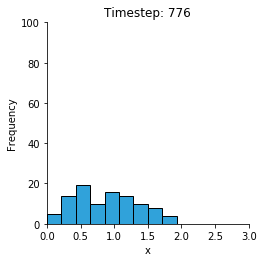
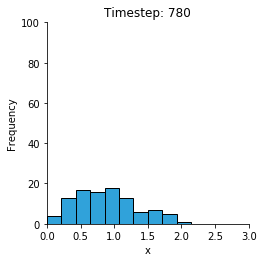
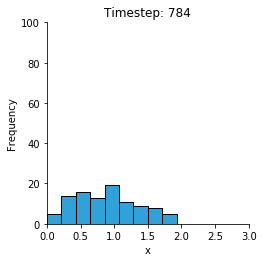
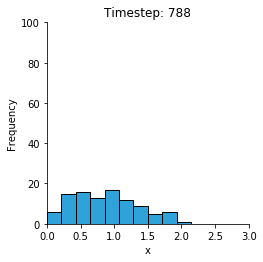
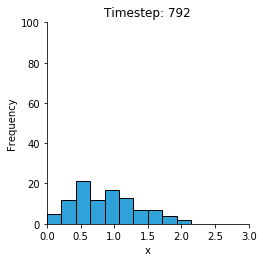
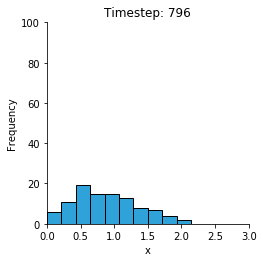
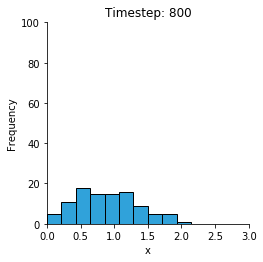
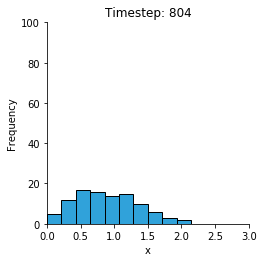
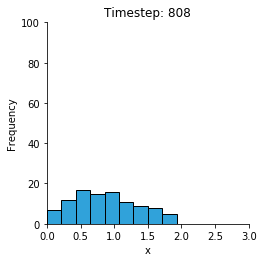
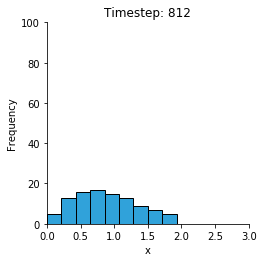
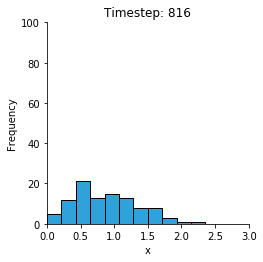
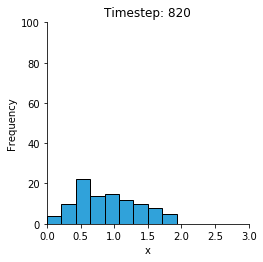
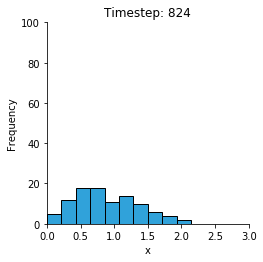
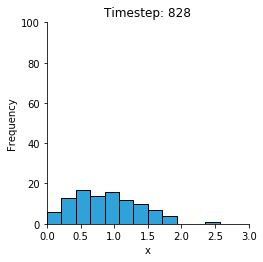
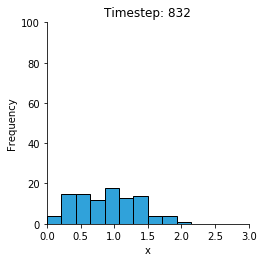
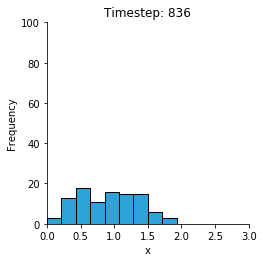
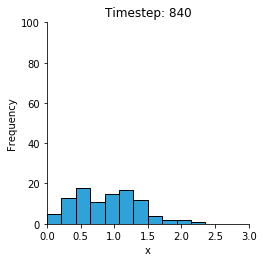
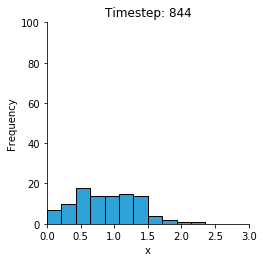
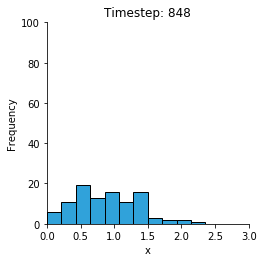
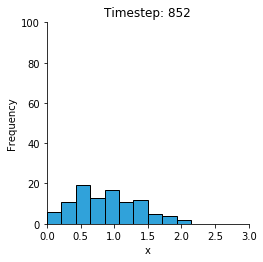
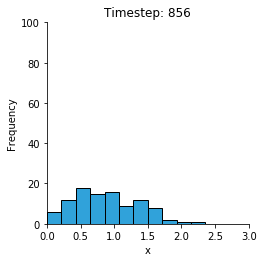
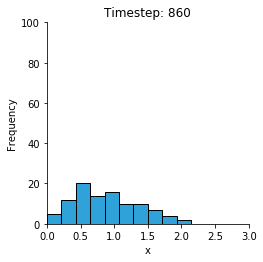
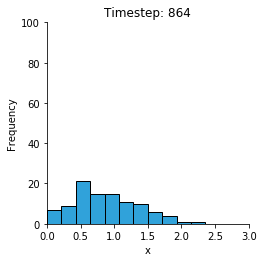
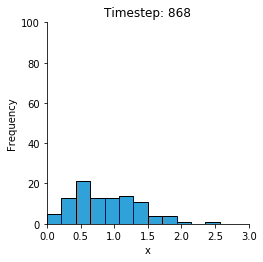
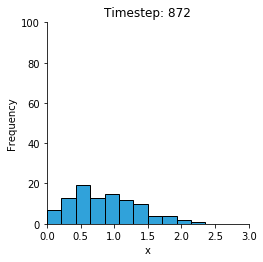
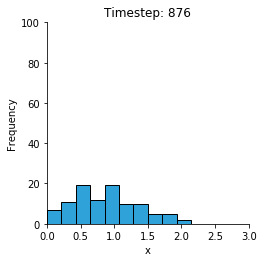
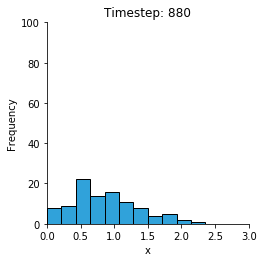
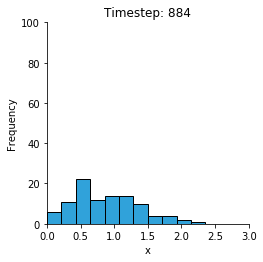
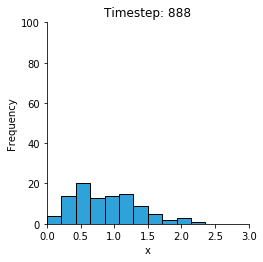
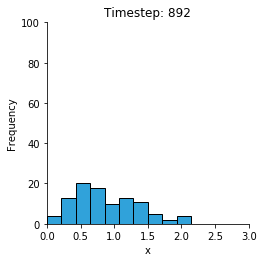
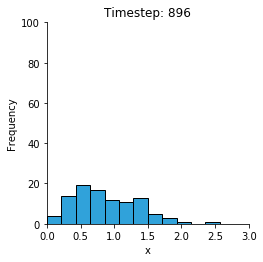
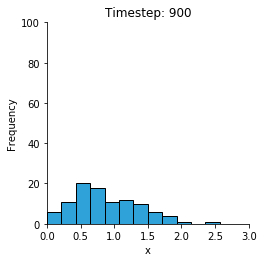
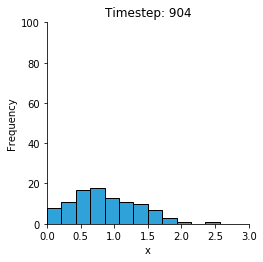
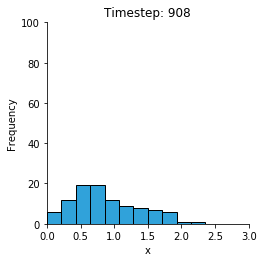
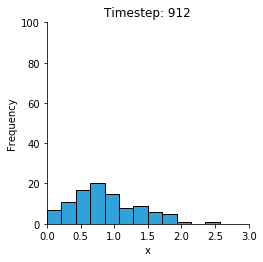
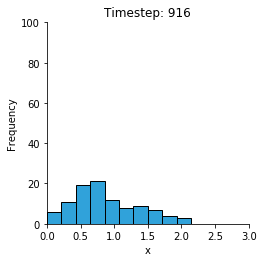
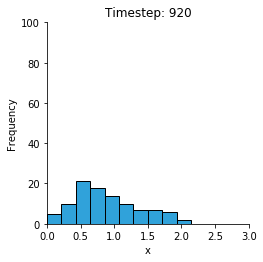
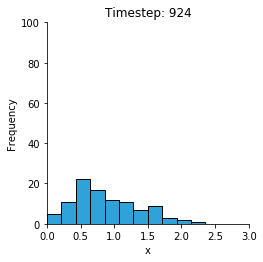
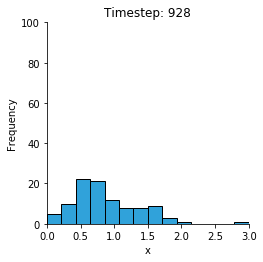
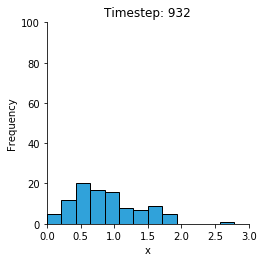
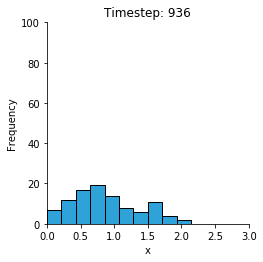
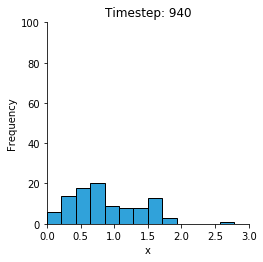
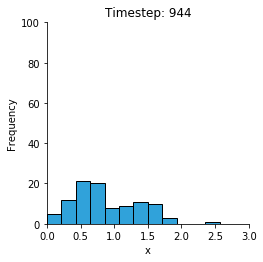
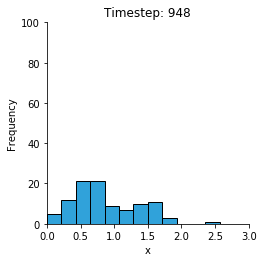
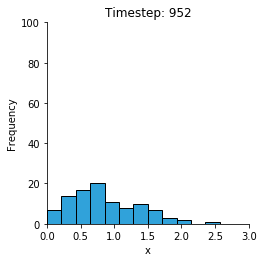
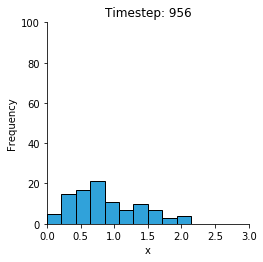
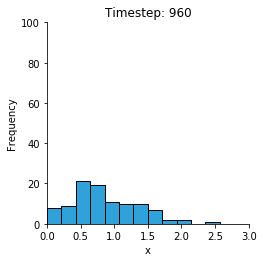
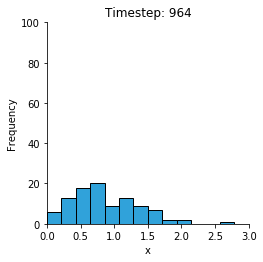
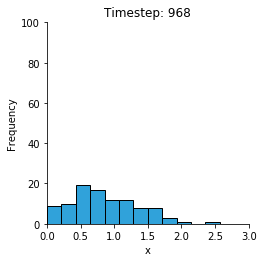
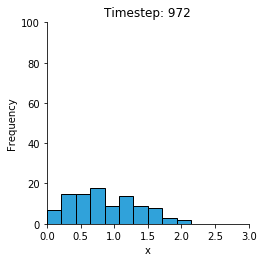
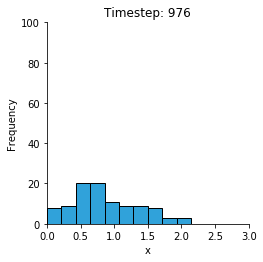
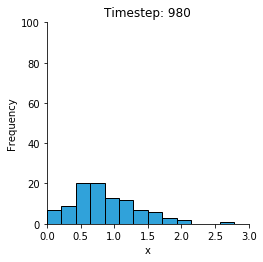
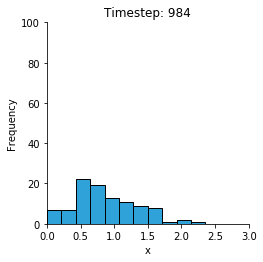
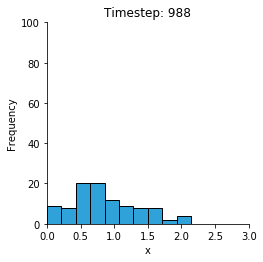
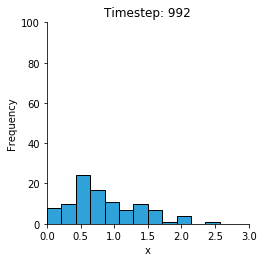
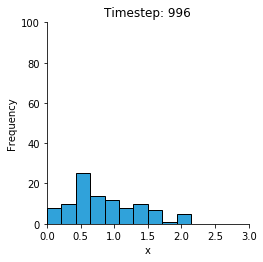
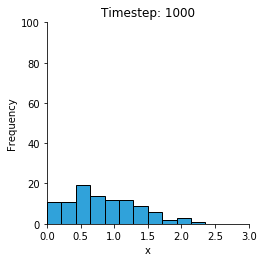

In [5]:
# velocity histogram slider plot
vel_hmap = hv.HoloMap(vel_dict_hv, kdims='Timestep')
vel_hmap